# TopicBank: Model Validation Experiment

Here we are going to estimate model quality using topic bank, which was created earlier in the notebook [Topic Bank Experiment: Bank Creation](TopicBank-Experiment-BankCreation.ipynb)

# Contents<a id="contents"></a>

* [Data Loading](#data-loading)
* [Bank Loading](#bank-loading)
* [Experiment](#experiment)
    * [Fixing Regularizer Parameters](#fixing-params)
        * [Decorrelation](#fixing-decorrelation)
        * [Topic Selection](#fixing-topic-selection)
        * [Sparsing](#fixing-sparsing)
        * [Smoothing](#fixing-smoothing)
    * [Model Quality Estimation](#model-quality-estimation)
        * [PLSA](#estimation-plsa)
        * [Regularized 1](#estimation-regularized1)
        * [Background Topics](#estimation-background)
        * [Arora & CDC](#estimation-arora-and-cdc)
        * [LDA, Sparse, Decorrelation & Regularized 2](#estimation-lda-and-all-all-all)
        * [Topic Selection & Decorrelation. All at Once but One after Another](#estimation-selection-plus-decorrelation1)
        * [Topic Selection & Decorrelation. Changing Parameters](#estimation-selection-plus-decorrelation2)
        * [Topic Selection & Decorrelation. Alternating Order](#estimation-selection-plus-decorrelation3)
        * [Topic Selection & Decorrelation. Alternating Order & Changing Parameters](#estimation-selection-plus-decorrelation4)
* [Results](#results)
    * [Step 0. Fixing Keys](#step0)
    * [Step 1. Averaging](#step1)
    * [Step 2. Aggregating](#step2)
    * [Step 3. Plots](#step3)

In [3]:
# General imports

import copy
import dill
import itertools
import json
import numpy as np
import os
import pandas as pd
import tempfile

from copy import deepcopy
from datetime import datetime
from enum import Enum
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
from tqdm import tqdm
from typing import (
    Callable,
    Dict,
    List,
)

%matplotlib inline

In [128]:
plt.rcParams['font.size']

10.0

In [129]:
plt.rcParams.update({'font.size': 20})

In [4]:
# Specific

from lapsolver import solve_dense

In [5]:
# Making `topnum` module visible for Python

import sys

sys.path.insert(0, '..')

In [43]:
# Optimal number of topics

import artm

from topicnet.cooking_machine import (
    Dataset,
    Experiment,
)
from topicnet.cooking_machine.cubes import (
    RegularizationControllerCube,
    RegularizersModifierCube,
)
from topicnet.cooking_machine.models import (
    TopicModel,
    BaseScore,
)
# from topicnet.cooking_machine.recipes import IntratextCoherenceRecipe
from topicnet.cooking_machine.model_constructor import add_standard_scores
from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.model_constructor import (
    init_model_from_family,
    KnownModel,
)
from topnum.scores import (
    IntratextCoherenceScore,
    SparsityPhiScore,
    SparsityThetaScore,
    SimpleTopTokensCoherenceScore,
    SophisticatedTopTokensCoherenceScore,
)
from topnum.scores._base_coherence_score import (
    SpecificityEstimationMethod,
    TextType,
    WordTopicRelatednessType
)
from topnum.scores.intratext_coherence_score import ComputationMethod
from topnum.search_methods import TopicBankMethod
from topnum.search_methods.topic_bank.topic_bank import TopicBank
from topnum.search_methods.topic_bank.one_model_train_funcs import (
    default_train_func,
    regularization_train_func,
    specific_initial_phi_train_func,
    background_topics_train_func,
    _get_topic_model,
    _fit_model_with_scores,
)
from topnum.search_methods.topic_bank.phi_initialization.initialize_phi_funcs import (
    initialize_with_copying_topics
)
from topnum.search_methods.topic_bank.phi_initialization.arora import (
    compute_phi as arora_compute_phi
)
from topnum.search_methods.topic_bank.phi_initialization.cdc import (
    compute_phi as cdc_compute_phi
)

## Data Loading<a id="data-loading"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [17]:
class DatasetName(Enum):
    POSTNAUKA = 'Post_Science'
    REUTERS = 'Reuters'
    BROWN = 'Brown'
    TWENTY_NEWSGROUPS = '20NG_natural_order'
    AG_NEWS = 'AG_News'
    WATAN = 'Watan2004'
    HABRAHABR = 'Habrahabr'

In [9]:
def get_dataset_internals_folder_path(dataset_name: DatasetName) -> str:
    return os.path.join('.', dataset_name.value + '__internals')

In [20]:
DATASET_NAME = DatasetName.POSTNAUKA  # select a dataset here

In [21]:
DATASET_NAME

<DatasetName.POSTNAUKA: 'Post_Science'>

In [22]:
DATASET_INTERNALS_FOLDER_PATH = get_dataset_internals_folder_path(
    DATASET_NAME
)

In [26]:
DATASET_INTERNALS_FOLDER_PATH

'./Post_Science__internals'

In [13]:
os.listdir(DATASET_INTERNALS_FOLDER_PATH)

['vw.txt',
 'cached_vw_texts',
 '.ipynb_checkpoints',
 'result_combined',
 'quality_estimates__wrong_cdc.json',
 'vocab.txt',
 'quality_estimates.json',
 'dict.dict.txt',
 'new_ppmi_tf_',
 'ppmi_tf_',
 'dict.dict',
 'cooc_values.json',
 'batches',
 'result']

In the folder below must reside the necessary data files in .csv format.

In [14]:
DATA_FOLDER_PATH = 'data'

In [15]:
sorted(os.listdir(DATA_FOLDER_PATH))

['.ipynb_checkpoints',
 '20NG_natural_order.csv',
 '20NG_natural_order_250.csv',
 '20NG_natural_order_40.csv',
 '20NG_natural_order_45.csv',
 '20NG_natural_order_50.csv',
 '20NG_natural_order_55.csv',
 '20NG_natural_order_60.csv',
 '20NG_natural_order_65.csv',
 'AG_News.csv',
 'AG_News_100.csv',
 'AG_News_1000.csv',
 'AG_News_10000.csv',
 'AG_News_250.csv',
 'AG_News_500.csv',
 'Brown.csv',
 'Brown_10.csv',
 'Brown_8.csv',
 'Brown_80.csv',
 'Brown_9.csv',
 'Habrahabr.csv',
 'Habrahabr_100.csv',
 'Habrahabr_15.csv',
 'Habrahabr_50.csv',
 'PScience.csv',
 'PostNauka_natural_order.csv',
 'Post_Science',
 'Post_Science_12.csv',
 'Post_Science_15.csv',
 'Post_Science_18.csv',
 'Post_Science_20.csv',
 'Post_Science_65.csv',
 'Reuters.csv',
 'Reuters_20.csv',
 'Reuters_50.csv',
 'Reuters_60.csv',
 'Reuters_80.csv',
 'Watan2004.csv',
 'Watan2004_10.csv',
 'Watan2004_100.csv',
 'Watan2004_12.csv',
 'Watan2004_15.csv',
 'Watan2004_250.csv']

In [23]:
DATASET_NAME_TO_DATASET_FILE_PATH = {
    DatasetName.POSTNAUKA: os.path.join(
        DATA_FOLDER_PATH, 'PostNauka_natural_order.csv'
    ),
    DatasetName.REUTERS: os.path.join(
        DATA_FOLDER_PATH, 'Reuters.csv'
    ),
    DatasetName.BROWN: os.path.join(
        DATA_FOLDER_PATH, 'Brown.csv'
    ),
    DatasetName.TWENTY_NEWSGROUPS: os.path.join(
        DATA_FOLDER_PATH, '20NG_natural_order.csv'
    ),
    DatasetName.AG_NEWS: os.path.join(
        DATA_FOLDER_PATH, 'AG_News.csv'
    ),
    DatasetName.WATAN: os.path.join(
        DATA_FOLDER_PATH, 'Watan2004.csv'
    ),
    DatasetName.HABRAHABR: os.path.join(
        DATA_FOLDER_PATH, 'Habrahabr.csv'
    ),
}

In [24]:
DATASET_FILE_PATH = DATASET_NAME_TO_DATASET_FILE_PATH[DATASET_NAME]

In [25]:
DATASET_FILE_PATH

'data/PostNauka_natural_order.csv'

In [27]:
%%time

# If using really big datasets (like Habrahabr),
# one may need to set this equal `False`
KEEP_DATASET_IN_MEMORY = True

DATASET = Dataset(
    DATASET_FILE_PATH,
    internals_folder_path=DATASET_INTERNALS_FOLDER_PATH,
    keep_in_memory=KEEP_DATASET_IN_MEMORY,
)

../../topicnet/cooking_machine/dataset.py:525: UserWarning: Attempted to use batches for different dataset.Overwriting batches in ./Post_Science__internals/batches
  warnings.warn(W_DIFF_BATCHES_1 + W_DIFF_BATCHES_2.format(self._batches_folder_path))


CPU times: user 5.53 s, sys: 229 ms, total: 5.76 s
Wall time: 2.99 s


In [28]:
if KEEP_DATASET_IN_MEMORY:
    DOCUMENTS = list(DATASET._data.index)
else:
    DOCUMENTS = list(DATASET._data_index)

NUM_DOCUMENTS = len(DOCUMENTS)

print(f'Num documents: {NUM_DOCUMENTS}')

Num documents: 3446


In [36]:
DATASET._data.head()

,id,raw_text,vw_text
id,,,
29998.txt,29998.txt,материал отрицательный показатель преломление ...,29998.txt |@word материал отрицательный показа...
7770.txt,7770.txt,культурный код экономика экономист александр а...,7770.txt |@word культурный код экономика эконо...
32230.txt,32230.txt,faq наука третий класс факт эксперимент резуль...,32230.txt |@word faq наука третий класс факт э...
27293.txt,27293.txt,обрушение волна поверхность жидкость математик...,27293.txt |@word обрушение волна поверхность ж...
481.txt,481.txt,существовать ли суперсимметрия мир элементарны...,481.txt |@word существовать ли суперсимметрия ...


In [21]:
DATASET._modalities

{'@word'}

Creating batches

In [37]:
DATASET.get_batch_vectorizer()

artm.BatchVectorizer(data_path="./Post_Science__internals/batches", num_batches=4)

Let's filter dictionary

In [68]:
dictionary = DATASET.get_dictionary()

In [69]:
dictionary

artm.Dictionary(name=d4bb2dae-c96b-4fea-bdef-a8065611afc7, num_entries=82162)

In [70]:
dictionary.filter(min_df_rate=0.01, max_df_rate=0.5)

artm.Dictionary(name=d4bb2dae-c96b-4fea-bdef-a8065611afc7, num_entries=5112)

Saving filtered dictionary

In [71]:
DATASET._cached_dict = dictionary

In [72]:
DATASET.get_dictionary()

artm.Dictionary(name=d4bb2dae-c96b-4fea-bdef-a8065611afc7, num_entries=5112)

In [73]:
artm_model = artm.ARTM(10)

artm_model.initialize(DATASET.get_dictionary())
artm_model.fit_offline(DATASET.get_batch_vectorizer(), 1)

KNOWN_WORDS = list(artm_model.get_phi().index)

del artm_model

In [74]:
KNOWN_WORDS[:10]

['сменить',
 'запрет',
 'вкус',
 'рыба',
 'тонкость',
 'культ',
 'присваивать',
 'сводиться',
 'презентация',
 'аналогично']

In [75]:
len(KNOWN_WORDS)

5112

## Bank Loading<a id="bank-loading"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [30]:
SEARCH_RESULTS_FOLDER_PATH = os.path.join(
    DATASET_INTERNALS_FOLDER_PATH,
    'result',
)

In [31]:
SEARCH_RESULTS_FOLDER_PATH

'./Post_Science__internals/result'

In [32]:
COMBINED_SEARCH_RESULT_FOLDER_PATH = os.path.join(
    DATASET_INTERNALS_FOLDER_PATH,
    'result_combined',
)

COMBINED_BANK_FOLDER_PATH = os.path.join(
    COMBINED_SEARCH_RESULT_FOLDER_PATH,
    'bank',
)

In [33]:
COMBINED_BANK_FOLDER_PATH

'./Post_Science__internals/result_combined/bank'

In [34]:
os.listdir(COMBINED_BANK_FOLDER_PATH)

['topic_scores.bin', 'topics.bin']

In [35]:
TOPIC_BANK = TopicBank(save=False, save_folder_path=COMBINED_BANK_FOLDER_PATH)

In [36]:
assert len(TOPIC_BANK.topics) > 0

len(TOPIC_BANK.topics)

24

In [38]:
BANK_PHI = TOPIC_BANK.view_topics()

In [40]:
BANK_PHI.shape

(2514, 24)

In [41]:
BANK_PHI.head()

topic_0  topic_1       topic_2       topic_3  \
@word както                  0.0  0.00000  5.497794e-11  0.000000e+00   
      гравитационный         0.0  0.00000  0.000000e+00  0.000000e+00   
      жена                   0.0  0.00139  0.000000e+00  0.000000e+00   
      продолжительность      0.0  0.00000  0.000000e+00  3.470690e-15   
      одновременно           0.0  0.00075  5.159791e-06  7.805681e-09   

                              topic_4       topic_5   topic_6       topic_7  \
@word както              1.985204e-08  2.223492e-14  0.000009  0.000000e+00   
      гравитационный     0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
      жена               0.000000e+00  1.217113e-04  0.000000  3.405896e-15   
      продолжительность  0.000000e+00  0.000000e+00  0.000000  4.282006e-04   
      одновременно       3.031660e-06  5.124066e-09  0.000146  8.667931e-13   

                          topic_8   topic_9  ...      topic_14      topic_15  \
@word както              0.000000  0.000000  ...  4.583967e-11  2.136343e-07   
      гравитационный     0.000000  0.022702  ...  0.000000e+00  0.000000e+00   
      жена               0.000000  0.000000  ...  8.552548e-05  4.613638e-11   
      продолжительность  0.000000  0.000000  ...  0.000000e+00  0.000000e+00   
      одновременно       0.000935  0.000564  ...  1.407077e-09  7.929910e-05   

                             topic_16  topic_17  topic_18  topic_19  topic_20  \
@word както              5.448506e-15  0.000001  0.000000  0.000002  0.000000   
      гравитационный     0.000000e+00  0.003760  0.000000  0.000000  0.005634   
      жена               0.000000e+00  0.000000  0.000252  0.000000  0.000000   
      продолжительность  7.503462e-05  0.000018  0.000000  0.000000  0.000000   
      одновременно       9.453733e-05  0.000171  0.000000  0.000424  0.000567   

                         topic_21      topic_22      topic_23  
@word както              0.000000  0.000000e+00  1.155988e-13  
      гравитационный     0.000000  0.000000e+00  0.000000e+00  
      жена               0.000000  0.000000e+00  0.000000e+00  
      продолжительность  0.000000  0.000000e+00  4.184186e-06  
      одновременно       0.001273  3.243302e-11  9.126395e-10  

[5 rows x 24 columns]

In [42]:
set(BANK_PHI.index.get_level_values(0))

{'@word'}

In [52]:
MODALITIES_OF_INTEREST = ['@word']
MAIN_MODALITY = '@word'

In [53]:
DATASET._extract_possible_modalities()

{'@word'}

In [59]:
BANK_PHI = BANK_PHI.loc[MODALITIES_OF_INTEREST]

In [60]:
BANK_PHI.head()

topic_0  topic_1       topic_2       topic_3  \
@word както                  0.0  0.00000  5.497794e-11  0.000000e+00   
      гравитационный         0.0  0.00000  0.000000e+00  0.000000e+00   
      жена                   0.0  0.00139  0.000000e+00  0.000000e+00   
      продолжительность      0.0  0.00000  0.000000e+00  3.470690e-15   
      одновременно           0.0  0.00075  5.159791e-06  7.805681e-09   

                              topic_4       topic_5   topic_6       topic_7  \
@word както              1.985204e-08  2.223492e-14  0.000009  0.000000e+00   
      гравитационный     0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
      жена               0.000000e+00  1.217113e-04  0.000000  3.405896e-15   
      продолжительность  0.000000e+00  0.000000e+00  0.000000  4.282006e-04   
      одновременно       3.031660e-06  5.124066e-09  0.000146  8.667931e-13   

                          topic_8   topic_9  ...      topic_14      topic_15  \
@word както              0.000000  0.000000  ...  4.583967e-11  2.136343e-07   
      гравитационный     0.000000  0.022702  ...  0.000000e+00  0.000000e+00   
      жена               0.000000  0.000000  ...  8.552548e-05  4.613638e-11   
      продолжительность  0.000000  0.000000  ...  0.000000e+00  0.000000e+00   
      одновременно       0.000935  0.000564  ...  1.407077e-09  7.929910e-05   

                             topic_16  topic_17  topic_18  topic_19  topic_20  \
@word както              5.448506e-15  0.000001  0.000000  0.000002  0.000000   
      гравитационный     0.000000e+00  0.003760  0.000000  0.000000  0.005634   
      жена               0.000000e+00  0.000000  0.000252  0.000000  0.000000   
      продолжительность  7.503462e-05  0.000018  0.000000  0.000000  0.000000   
      одновременно       9.453733e-05  0.000171  0.000000  0.000424  0.000567   

                         topic_21      topic_22      topic_23  
@word както              0.000000  0.000000e+00  1.155988e-13  
      гравитационный     0.000000  0.000000e+00  0.000000e+00  
      жена               0.000000  0.000000e+00  0.000000e+00  
      продолжительность  0.000000  0.000000e+00  4.184186e-06  
      одновременно       0.001273  3.243302e-11  9.126395e-10  

[5 rows x 24 columns]

In [61]:
BANK_PHI['topic_23'].sort_values(ascending=False)[:10]

@word  проблема      0.195973
       задача        0.140297
       решать        0.068049
       решение       0.040787
       мышление      0.026376
       творческий    0.010622
       процесс       0.010458
       разный        0.010243
       перед         0.009838
       решаться      0.009392
Name: topic_23, dtype: float64

In [16]:
class QualityEstimates:
    def __init__(self):
        self._save_file_path = os.path.join(
            DATASET_INTERNALS_FOLDER_PATH,
            'quality_estimates.json',
        )
        
        if os.path.isfile(self._save_file_path):
            self._model2estimates = json.loads(open(self._save_file_path, 'r').read())
        else:
            self._model2estimates = dict()

        self._last_estimates = None
    
    def train_models_and_estimate_quality(self, train_func, model_name_prefix, seeds=None) -> dict:
        if seeds is None:
            seeds = DEFAULT_SEEDS

        result = dict()

        for seed in tqdm(seeds, total=len(seeds), file=sys.stdout):
            topic_model = train_func(
                dataset=DATASET,
                model_number=seed,
                num_topics=NUM_TOPICS,
                num_fit_iterations=NUM_FIT_ITERATIONS,
            )
            model_name = f'{model_name_prefix}_{seed}'

            result[model_name] = self._estimate_model_quality(
                topic_model=topic_model,
            )

        self.update(result)

        return result
    
    def update(self, estimates):
        self._model2estimates.update(copy.deepcopy(estimates))
        self.save()
    
    def save(self) -> None:
        with open(self._save_file_path, 'w') as f:
            f.write(json.dumps(self._model2estimates))
    
    @classmethod
    def _estimate_model_quality(cls, topic_model, model_phi = None) -> Dict[str, float or List[str]]:
        if model_phi is None:
            model_phi = topic_model.get_phi().loc[MODALITIES_OF_INTEREST]

        costs = [
            [
                TopicBankMethod._jaccard_distance(
                    model_phi.loc[:, model_topic].to_dict(),
                    BANK_PHI.loc[:, bank_topic].to_dict()
                )
                for bank_topic in BANK_PHI.columns
            ]
            for model_topic in model_phi.columns
        ]

        costs = np.array(costs, dtype=np.float32)

        rids, cids = solve_dense(costs)

        result = dict()

        for distance_threshold in np.arange(0.10, 0.91, 0.05):
            num_good_topics = 0
            found_topics = list()

            for r, c in zip(rids, cids):
                if np.min(costs[r, :]) < distance_threshold:
                    num_good_topics += 1

                if np.min(costs[:, c]) < distance_threshold:
                    found_topics.append(BANK_PHI.columns[c])

            num_found_topics = len(found_topics)

            current_result = dict()

            num_model_topics = model_phi.shape[1]
            num_bank_topics = BANK_PHI.shape[1]

            current_result['num_good_topics'] = num_good_topics
            current_result['num_found_topics'] = num_found_topics
            current_result['found_topics'] = found_topics

            current_result['coherence@bank'] = num_good_topics / max(1, num_model_topics)
            current_result['precision@bank'] = num_found_topics / max(1, num_model_topics)
            current_result['recall@bank'] = num_found_topics / max(1, num_bank_topics)
            current_result['cost'] = float(np.sum(costs[rids, cids]))

            # TODO: comment
            current_result['_num_model_topics'] = num_model_topics
            current_result['_num_bank_topics'] = num_bank_topics

            result[distance_threshold] = current_result

        return result

## Experiment<a id="experiment"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/demos/Making-Decorrelation-and-Topic-Selection-Friends.ipynb

In [44]:
SPARSE_PHI_SPECIFIC = 'sparse_phi_specific'
SPARSE_THETA_SPECIFIC = 'sparse_theta_specific'
SMOOTH_PHI_BACKGROUND = 'smooth_phi_background'
SMOOTH_THETA_BACKGROUND = 'smooth_theta_background'

DECORRELATE_SPECIFIC = 'decorrelate_specific'
DECORRELATE_BACKGROUND = 'decorrelate_background'

SELECT_TOPICS = 'select_topics'


def initialize_smoothing_sparsing_regularizers(
        specific_topic_names,
        background_topic_names,
        specific_class_ids,
        background_class_ids):

    return [
        artm.SmoothSparsePhiRegularizer(
            tau=0,
            name=SPARSE_PHI_SPECIFIC,
            topic_names=specific_topic_names,
            class_ids=specific_class_ids
        ),
        artm.SmoothSparseThetaRegularizer(
            tau=0,
            name=SPARSE_THETA_SPECIFIC,
            topic_names=specific_topic_names
        ),
        artm.SmoothSparsePhiRegularizer(
            tau=0,
            name=SMOOTH_PHI_BACKGROUND,
            topic_names=background_topic_names,
            class_ids=background_class_ids
        ),
        artm.SmoothSparseThetaRegularizer(
            tau=0,
            name=SMOOTH_THETA_BACKGROUND,
            topic_names=background_topic_names
        ),
    ]


def initialize_decorrelating_regularizers(
        specific_topic_names,
        background_topic_names,
        specific_class_ids,
        background_class_ids):

    return [
        artm.DecorrelatorPhiRegularizer(
            tau=0,
            name=DECORRELATE_SPECIFIC,
            topic_names=specific_topic_names,
            class_ids=specific_class_ids,
        ),
        artm.DecorrelatorPhiRegularizer(
            tau=0,
            name=DECORRELATE_BACKGROUND,
            topic_names=background_topic_names,
            class_ids=background_class_ids,
        )
    ]


def initialize_topic_selecting_regularizers(specific_topic_names):
    return [
        artm.TopicSelectionThetaRegularizer(
            tau=0,
            name=SELECT_TOPICS,
            topic_names=specific_topic_names
        )
    ]

In [45]:
WORKING_FOLDER_PATH = tempfile.mkdtemp()

In [46]:
WORKING_FOLDER_PATH

'/tmp/tmptld9bxl7'

In [47]:
class ActiveTopicNumberScore(BaseScore):
    """
    Calculates number of active topics, i.e. those ones which have at least one document
    
    """
    def __init__(self, specific_topic_names, dataset, threshold=0):
        """
        threshold — minimum probability p(t | d) to consider the document "d" to be related to the topic "t"
        
        """
        super().__init__()
        
        self._threshold = threshold
        self._specific_topic_names = specific_topic_names
        self._dataset = dataset  # TODO: cache theta didn't work for some reason, so can't do without dataset...
        
        self._dataset_file_path = dataset._data_path
        self._dataset_internals_folder_path = dataset._internals_folder_path
        self._keep_dataset_in_memory = dataset._small_data

    def call(self, model):
        return len(self.get_active_topics(model))
    
    def get_active_topics(self, model):
        if len(self._specific_topic_names) == 0:
            raise RuntimeError()

        theta = model._model.transform(self._dataset.get_batch_vectorizer())
        subtheta_values = theta.loc[self._specific_topic_names, :].values
        max_probs = np.max(subtheta_values, axis=1)
        
        return list(np.where(max_probs > self._threshold)[0])

    # TODO: DRY
    def save(self, path: str) -> None:
        dataset = self._dataset
        self._dataset = None

        with open(path, 'wb') as f:
            dill.dump(self, f)

        self._dataset = dataset

    @classmethod
    def load(cls, path: str):
        with open(path, 'rb') as f:
            score = dill.load(f)

        score._dataset = Dataset(
            score._dataset_file_path,
            internals_folder_path=score._dataset_internals_folder_path,
            keep_in_memory=score._keep_dataset_in_memory,
        )

        return score

In [48]:
NUM_SPECIFIC_TOPICS = 100
NUM_BACKGROUND_TOPICS = 2
NUM_TOPICS = NUM_SPECIFIC_TOPICS + NUM_BACKGROUND_TOPICS

SPECIFIC_TOPIC_NAMES = [f'spec_topic_{i}' for i in range(NUM_SPECIFIC_TOPICS)]
BACKGROUND_TOPIC_NAMES = [f'back_topic_{i}' for i in range(NUM_BACKGROUND_TOPICS)]

PERPLEXITY_SCORE = 'PerplexityScore'         # don't change this, as it is defined this way in TopicNet's function
SPARSITY_PHI_SCORE = 'SparsityPhiScore'      # ...and this
SPARSITY_THETA_SCORE = 'SparsityThetaScore'  # ...and this
TOPIC_KERNEL_SCORE = 'TopicKernel'           # ...and this


def initialize_topic_model():
    artm_model = artm.ARTM(
        num_processors=1,  # can be changed for faster computing, but here we won't use it
        topic_names=SPECIFIC_TOPIC_NAMES + BACKGROUND_TOPIC_NAMES,
        cache_theta=True,  # TODO: even with True fails to get theta inside scores
        class_ids={
            MAIN_MODALITY: 1.0
        },
        num_document_passes=1,
        dictionary=DATASET.get_dictionary()
    )

    smoothing_sparsing_regularizers = initialize_smoothing_sparsing_regularizers(
        SPECIFIC_TOPIC_NAMES, BACKGROUND_TOPIC_NAMES, [MAIN_MODALITY], [MAIN_MODALITY]
    )
    decorrelating_regularizers = initialize_decorrelating_regularizers(
        SPECIFIC_TOPIC_NAMES, BACKGROUND_TOPIC_NAMES, [MAIN_MODALITY], [MAIN_MODALITY]
    )
    topic_selecting_regularizers = initialize_topic_selecting_regularizers(
        SPECIFIC_TOPIC_NAMES
    )

    for regularizer in smoothing_sparsing_regularizers + decorrelating_regularizers + topic_selecting_regularizers:
        artm_model.regularizers.add(regularizer, overwrite=True)

    add_standard_scores(
        artm_model,
        DATASET.get_dictionary(),
        main_modality=MAIN_MODALITY,
        all_modalities=MODALITIES_OF_INTEREST,
    )

    topic_model = TopicModel(
        artm_model,
        model_id='Root Model',
    )

    experiment = Experiment(
        experiment_id=datetime.now().strftime('%Y-%m-%d__%H-%M-%S'),
        save_path=os.path.join(WORKING_FOLDER_PATH, 'Experiments'),
        topic_model=topic_model
    )
    
    return topic_model

In [68]:
def select_best_model_of_all(
        experiment: Experiment,
        score_name: str = None,
        maximize: bool = None) -> TopicModel:

    if score_name is None:
        score_name = PERPLEXITY_SCORE + MAIN_MODALITY
        maximize = False
    elif maximize is None:
        maximize = True

    best_model = None
    levels = range(1, len(experiment.cubes) + 1)
    
    if maximize:
        criterion = f'{score_name} -> max'
        
        def is_candidate_better_func(candidate_model) -> bool:
            return candidate_model.scores[score_name][-1] > best_model.scores[score_name][-1]
    else:
        criterion = f'{score_name} -> min'
        
        def is_candidate_better_func(candidate_model) -> bool:
            return candidate_model.scores[score_name][-1] < best_model.scores[score_name][-1]

    # TODO: probably need such method in Experiment?
    #  (i.e. "select best of all", not only on level=level)
    for level in levels:
        best_model_candidates = experiment.select(
            criterion,
            level=level
        )

        if len(best_model_candidates) == 0:
            continue

        best_model_candidate = best_model_candidates[0]

        if best_model is None or is_candidate_better_func(best_model_candidate):

            best_model = best_model_candidate
    
    return best_model

### Fixing Regularizer Parameters<a id="fixing-params"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [134]:
NUM_CUBE_ITERATIONS = 20  # if dataset is big, maybe better to reduce

#### Decorrelation<a id="fixing-decorrelation"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [69]:
# Decorr

decorrelating_regularizer_parameters = {
    'regularizer': artm.DecorrelatorPhiRegularizer(
        tau=0,
        name=DECORRELATE_SPECIFIC,
        topic_names=SPECIFIC_TOPIC_NAMES,
        class_ids=[MAIN_MODALITY],
    ),
    'tau_grid': [1, 10, 100, 1000, 1e4, 1e5, 1e6]
}

decorrelating_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=decorrelating_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [70]:
decorrelating_cube.parameters

[{'object': <artm.regularizers.DecorrelatorPhiRegularizer at 0x7f9e84c66320>,
  'field': 'tau',
  'values': [1, 10, 100, 1000, 10000.0, 100000.0, 1000000.0]}]

In [71]:
topic_model = initialize_topic_model()

In [72]:
%%time

models = decorrelating_cube(topic_model, DATASET)  # TODO: nice cube output

CPU times: user 1h 58min 53s, sys: 19.1 s, total: 1h 59min 12s
Wall time: 1h 53min 2s


In [73]:
models[0].scores

{'PerplexityScore@all': [2306.915283203125],
 'SparsityThetaScore': [0.0],
 'SparsityPhiScore@word': [0.0],
 'PerplexityScore@word': [2306.915283203125],
 'TopicKernel@word.average_coherence': [0.0],
 'TopicKernel@word.average_contrast': [0.0213612113147974],
 'TopicKernel@word.average_purity': [0.0030727647244930267],
 'TopicKernel@word.average_size': [0.38235294818878174],
 'TopicKernel@word.coherence': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.contrast': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.purity': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.size': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.tokens': ["NaN (<class 'dict'>)"],
 'ITMScore_89563104-e102-46c7-b2ef-260c1e1aa0de': [1.0]}

In [74]:
topic_model.experiment.models

{'-----------root-----------': Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-10__02-20-58),
 '--02h21m03s_10d05m2020y---': Model(id=--02h21m03s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__02-20-58),
 '--02h37m09s_10d05m2020y---': Model(id=--02h37m09s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__02-20-58),
 '--02h53m20s_10d05m2020y---': Model(id=--02h53m20s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__02-20-58),
 '--03h09m27s_10d05m2020y---': Model(id=--03h09m27s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__02-20-58),
 '--03h25m38s_10d05m2020y---': Model(id=--03h25m38s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__02-20-58),
 '--03h41m44s_10d05m2020y---': Model(id=--03h41m44s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__02-20-58),
 '--03h57m52s_10d05m2

In [86]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

In [87]:
best_model

Model(id=--03h57m52s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__02-20-58)

In [77]:
best_model.regularizers

[sparse_phi_specific, sparse_theta_specific, smooth_phi_background, smooth_theta_background, decorrelate_specific, decorrelate_background, select_topics]

In [88]:
DECORRELATION_TAU = best_model.regularizers[DECORRELATE_SPECIFIC].tau

In [89]:
DECORRELATION_TAU

1000000.0

In [122]:
models[0].scores

{'PerplexityScore@all': [1888.0941162109375],
 'SparsityThetaScore': [0.0],
 'SparsityPhiScore@word': [0.0],
 'PerplexityScore@word': [1888.0941162109375],
 'TopicKernel@word.average_coherence': [0.0],
 'TopicKernel@word.average_contrast': [0.009224922396242619],
 'TopicKernel@word.average_purity': [0.002170576946809888],
 'TopicKernel@word.average_size': [0.22549019753932953],
 'TopicKernel@word.coherence': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.contrast': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.purity': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.size': ["NaN (<class 'dict'>)"],
 'TopicKernel@word.tokens': ["NaN (<class 'dict'>)"],
 'ITMScore_f9056493-46d1-4b4d-850b-e038c137f212': [1.0]}

In [93]:
list(best_model.scores.keys())

['PerplexityScore@all',
 'SparsityThetaScore',
 'SparsityPhiScore@word',
 'PerplexityScore@word',
 'TopicKernel@word.average_coherence',
 'TopicKernel@word.average_contrast',
 'TopicKernel@word.average_purity',
 'TopicKernel@word.average_size',
 'TopicKernel@word.coherence',
 'TopicKernel@word.contrast',
 'TopicKernel@word.purity',
 'TopicKernel@word.size',
 'TopicKernel@word.tokens',
 'ITMScore_9c7d4c86-c902-4f23-a23e-a114e584f593']

In [94]:
best_model.scores['TopicKernel@word.average_size']

[0.0,
 0.05882352963089943,
 0.05882352963089943,
 0.0784313753247261,
 0.19607843458652496,
 0.3333333432674408,
 0.9215686321258545,
 1.156862735748291,
 1.4313725233078003,
 1.5686274766921997]

In [52]:
DEFAULT_SCORES_TO_PLOT = [
    'PerplexityScore@all',
    f'TopicKernel{MAIN_MODALITY}.average_size',
    f'SparsityPhiScore{MAIN_MODALITY}',
    'SparsityThetaScore',
]

In [53]:
def draw_plots(model, scores=None, num_cols=2, font_size=10):
    if scores is None:
        scores = DEFAULT_SCORES_TO_PLOT
    
    old_font_size = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': font_size})
    
    num_rows = int(np.ceil(len(scores) / num_cols))

    one_plot_width = 4
    one_plot_heigth = 7
    
    fig, axes = plt.subplots(
        num_rows, num_cols,
        figsize=(num_cols * one_plot_heigth, num_rows * one_plot_width)
    )
    
    iterations = list(range(1, len(model.scores[scores[0]]) + 1))
    
    for i, score in enumerate(scores):
        if num_rows >= 2:
            ax = axes[i // num_cols][i % num_cols]
        else:
            ax = axes[i]
        
        ax.plot(iterations, model.scores[score], lw=5)
        
        ax.set_ylabel(score)
        ax.set_xlabel('Iteration')

    plt.subplots_adjust(
        hspace=0.25, wspace=0.25
    )
    plt.show()
    
    plt.rcParams.update({'font.size': old_font_size})

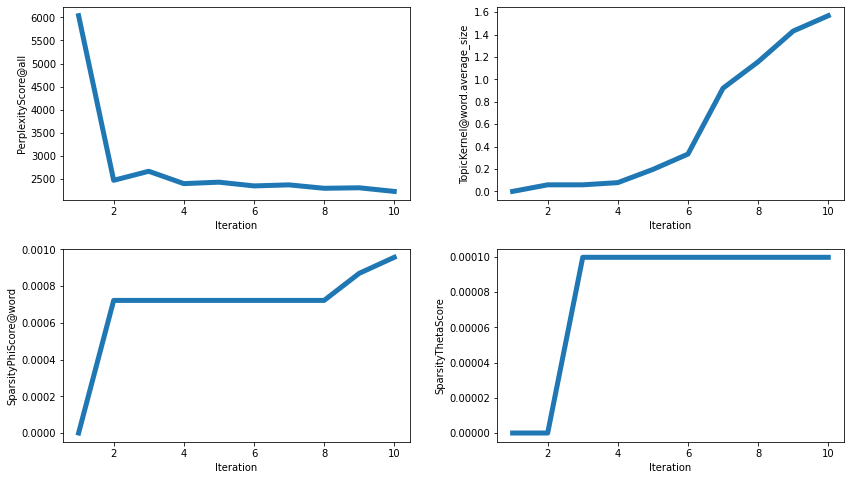

In [95]:
draw_plots(best_model)

In [ ]:
del models
del best_model

#### Topic Selection<a id="fixing-topic-selection"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [97]:
selecting_regularizer_parameters = {
    'regularizer': artm.TopicSelectionThetaRegularizer(
        tau=0,
        name=SELECT_TOPICS,
        topic_names=SPECIFIC_TOPIC_NAMES
    ),
    'tau_grid': [0.01, 0.1, 0.2, 0.5, 0.8, 1.0, 1.5, 2.0]
}

selecting_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=selecting_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [98]:
selecting_cube.parameters

[{'object': <artm.regularizers.TopicSelectionThetaRegularizer at 0x7f9e77216780>,
  'field': 'tau',
  'values': [0.01, 0.1, 0.2, 0.5, 0.8, 1.0, 1.5, 2.0]}]

In [99]:
topic_model = initialize_topic_model()

In [100]:
%%time

models = selecting_cube(topic_model, DATASET)

CPU times: user 1h 8min 19s, sys: 6 s, total: 1h 8min 25s
Wall time: 1h 3min 49s


In [ ]:
score = ActiveTopicNumberScore(
    SPECIFIC_TOPIC_NAMES,
    DATASET,
    threshold=1e-7
)

In [101]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

../../topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-10__09-17-31)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
../../topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [102]:
best_model.get_phi().shape

(6056, 102)

In [173]:
score.call(best_model)

0

In [175]:
for m in models:
    m = m.restore()
    print(m)
    print(score.call(m))
    print(m.regularizers[SELECT_TOPICS].tau)
    print()

Model(id=--21h09m06s_09d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-09__21-09-06)
100
0.01

Model(id=--21h11m02s_09d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-09__21-09-06)
100
0.1

Model(id=--21h12m57s_09d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-09__21-09-06)
100
0.2

Model(id=--21h14m53s_09d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-09__21-09-06)
99
0.5

Model(id=--21h16m49s_09d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-09__21-09-06)
39
0.8

Model(id=--21h18m45s_09d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-09__21-09-06)
0
1.0

Model(id=--21h20m39s_09d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-09__21-09-06)
0
1.5

Model(id=--21h22m32s_09d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-09__21-09-06)
0
2.0



In [106]:
SELECTION_TAU = best_model.regularizers[SELECT_TOPICS].tau

In [107]:
SELECTION_TAU

0.5

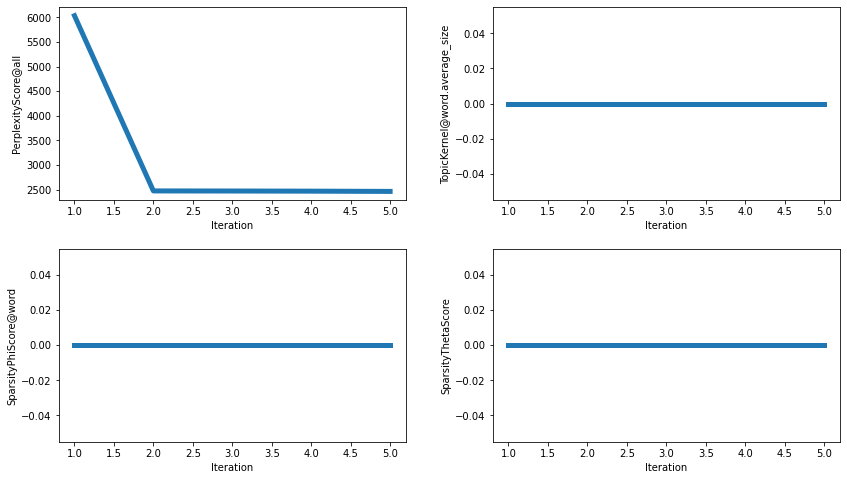

In [105]:
draw_plots(best_model)

In [138]:
best_model.get_phi()['spec_topic_12'].sort_values(ascending=False)

modality  token
@word     سكن      0.0
          لاجل     0.0
          بكاف     0.0
          عميق     0.0
          رقاب     0.0
                  ... 
          شارك     0.0
          امثل     0.0
          طلابي    0.0
          شوق      0.0
          هرير     0.0
Name: spec_topic_12, Length: 4062, dtype: float32

In [108]:
del best_model
del models

#### Sparsing<a id="fixing-sparsing"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [109]:
sparsing_regularizer_parameters = {
    'regularizer': artm.SmoothSparsePhiRegularizer(
        tau=0,
        name=SPARSE_PHI_SPECIFIC,
        topic_names=SPECIFIC_TOPIC_NAMES,
        class_ids=[MAIN_MODALITY]
    ),
    'tau_grid': [-10, -1, -0.2, -0.1, -0.02, -0.01, -0.001]
}

sparsing_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=sparsing_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [110]:
sparsing_cube.parameters

[{'object': <artm.regularizers.SmoothSparsePhiRegularizer at 0x7f9e77167128>,
  'field': 'tau',
  'values': [-10, -1, -0.2, -0.1, -0.02, -0.01, -0.001]}]

In [111]:
topic_model = initialize_topic_model()

In [112]:
%%time

models = sparsing_cube(topic_model, DATASET)

CPU times: user 1h 34s, sys: 9.35 s, total: 1h 43s
Wall time: 56min 20s


In [113]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

../../topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-10__10-24-40)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
../../topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [114]:
best_model

Model(id=--10h24m42s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__10-24-40)

In [145]:
for m in models:
    print(m.model_id, m.scores['PerplexityScore@all'][-1])

--20h37m35s_09d05m2020y--- 1558.9627685546875
--20h39m30s_09d05m2020y--- 1819.438720703125
--20h41m24s_09d05m2020y--- 1873.24072265625
--20h43m18s_09d05m2020y--- 1880.580078125
--20h45m13s_09d05m2020y--- 1886.5706787109375
--20h47m06s_09d05m2020y--- 1887.331298828125
--20h49m01s_09d05m2020y--- 1888.018310546875


In [115]:
SPARSING_TAU = best_model.regularizers[SPARSE_PHI_SPECIFIC].tau

In [116]:
SPARSING_TAU

-10

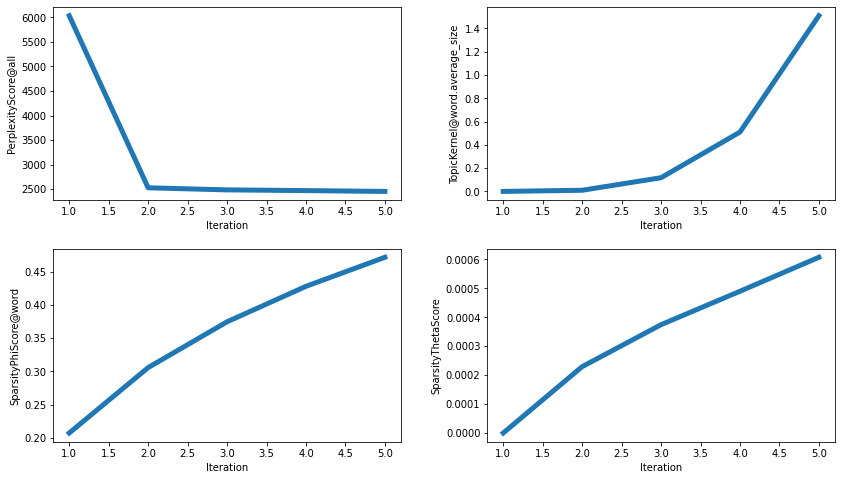

In [117]:
draw_plots(best_model)

In [ ]:
del best_model
del models

#### Smoothing<a id="fixing-smoothing"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [118]:
smoothing_regularizer_parameters = {
    'regularizer': artm.SmoothSparsePhiRegularizer(
        tau=0,
        name=SMOOTH_PHI_BACKGROUND,
        topic_names=BACKGROUND_TOPIC_NAMES,
        class_ids=[MAIN_MODALITY]
    ),
    'tau_grid': [0.001, 0.01, 0.02, 0.1, 1.0, 10.0]
}

smoothing_cube = RegularizersModifierCube(
    num_iter=NUM_CUBE_ITERATIONS,
    regularizer_parameters=smoothing_regularizer_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False
)

In [119]:
smoothing_cube.parameters

[{'object': <artm.regularizers.SmoothSparsePhiRegularizer at 0x7f9e76c75e80>,
  'field': 'tau',
  'values': [0.001, 0.01, 0.02, 0.1, 1.0, 10.0]}]

In [120]:
topic_model = initialize_topic_model()

In [121]:
%%time

models = smoothing_cube(topic_model, DATASET)

CPU times: user 52min 47s, sys: 11.3 s, total: 52min 58s
Wall time: 48min 20s


In [122]:
topic_model.experiment.models

{'-----------root-----------': Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-10__11-21-02),
 '--11h21m04s_10d05m2020y---': Model(id=--11h21m04s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__11-21-02),
 '--11h29m05s_10d05m2020y---': Model(id=--11h29m05s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__11-21-02),
 '--11h37m06s_10d05m2020y---': Model(id=--11h37m06s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__11-21-02),
 '--11h45m08s_10d05m2020y---': Model(id=--11h45m08s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__11-21-02),
 '--11h53m12s_10d05m2020y---': Model(id=--11h53m12s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__11-21-02),
 '--12h01m15s_10d05m2020y---': Model(id=--12h01m15s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__11-21-02)}

In [123]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

../../topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-10__11-21-02)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
../../topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [124]:
best_model

Model(id=--12h01m15s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__11-21-02)

In [125]:
SMOOTHING_TAU = best_model.regularizers[SMOOTH_PHI_BACKGROUND].tau

In [126]:
SMOOTHING_TAU

10.0

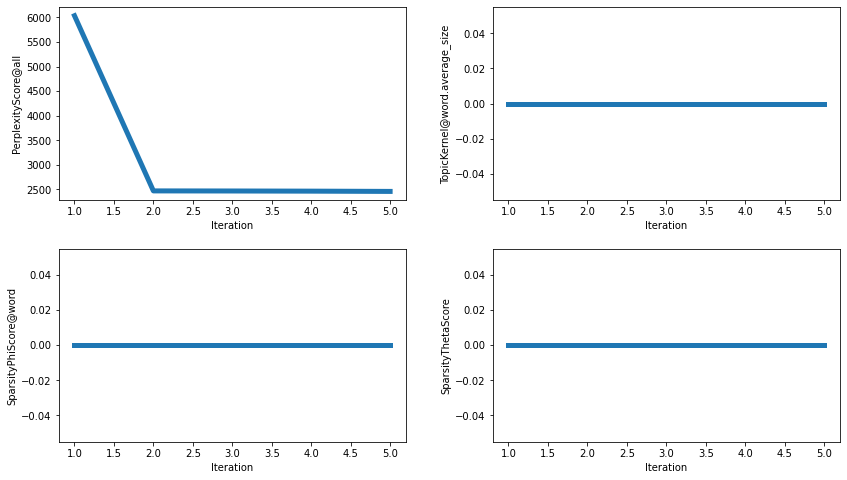

In [127]:
draw_plots(best_model)

In [ ]:
del models
del best_model

### Model Quality Estimation<a id="model-quality-estimation"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [69]:
DEFAULT_SEED = 0
NUM_TOPICS = 100
NUM_FIT_ITERATIONS = 100  # with big datasets — better change this to something lower

DEFAULT_SEEDS = [0, 1, 2]

In [17]:
ESTIMATES = QualityEstimates()

In [69]:
ESTIMATES._save_file_path

'./Post_Science__internals/quality_estimates.json'

#### PLSA<a id="estimation-plsa"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [132]:
%%time

plsa_quality = ESTIMATES.train_models_and_estimate_quality(default_train_func, 'plsa')

100%|██████████| 3/3 [04:28<00:00, 89.60s/it]
CPU times: user 2h 9min 41s, sys: 1min 1s, total: 2h 10min 42s
Wall time: 4min 28s


In [133]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2'])

#### Regularized 1<a id="estimation-regularized1"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [135]:
def regularization_train_func(
        dataset: Dataset,
        model_number: int,
        num_topics: int,
        num_fit_iterations: int,
        scores: List[BaseScore] = None,
        decorrelating_tau: float = 10**5,
        smoothing_tau: float = 1e-5,
        sparsing_tau: float = -0.01,
        **kwargs) -> TopicModel:

    topic_model = _get_topic_model(
        dataset,
        num_topics=num_topics,
        seed=model_number,
        **kwargs,
    )

    topic_model._model.regularizers.add(
        artm.regularizers.DecorrelatorPhiRegularizer(tau=decorrelating_tau)
    )

    for topic_name in list(topic_model.get_phi().columns):
        topic_model._model.regularizers.add(
            artm.regularizers.SmoothSparsePhiRegularizer(
                tau=smoothing_tau,
                topic_names=topic_name
            )
        )

    num_fit_iterations_with_scores = 1
    first_num_fit_iterations = int(
        0.75 * (num_fit_iterations - num_fit_iterations_with_scores)
    )
    second_num_fit_iterations = (
        num_fit_iterations - num_fit_iterations_with_scores - first_num_fit_iterations
    )

    topic_model._fit(
        dataset.get_batch_vectorizer(),
        num_iterations=first_num_fit_iterations
    )

    for regularizer_name in topic_model._model.regularizers.data:
        topic_model._model.regularizers[regularizer_name].tau = 0

    topic_model._model.regularizers.add(
        artm.regularizers.SmoothSparsePhiRegularizer(tau=sparsing_tau)
    )

    topic_model._fit(
        dataset.get_batch_vectorizer(),
        num_iterations=max(0, second_num_fit_iterations - num_fit_iterations_with_scores)
    )
    _fit_model_with_scores(
        topic_model,
        dataset,
        scores,
        num_fit_iterations=num_fit_iterations_with_scores
    )

    return topic_model

In [136]:
reqularized_quality = ESTIMATES.train_models_and_estimate_quality(
    lambda dataset, model_number, num_topics, num_fit_iterations: regularization_train_func(
        dataset, model_number, num_topics, num_fit_iterations,
        decorrelating_tau=DECORRELATION_TAU,
        sparsing_tau=SPARSING_TAU,
    ),
    'regularized',
)

100%|██████████| 3/3 [04:04<00:00, 81.58s/it]


#### Background Topics<a id="estimation-background"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [137]:
background_topics_quality = ESTIMATES.train_models_and_estimate_quality(
    lambda dataset, model_number, num_topics, num_fit_iterations: background_topics_train_func(
        dataset, model_number, num_topics, num_fit_iterations, smoothing_tau=SMOOTHING_TAU
    ),
    'background_topics',
)

100%|██████████| 3/3 [09:02<00:00, 180.78s/it]


In [210]:
background_topics_quality.keys()

dict_keys(['background_topics_0', 'background_topics_1', 'background_topics_2'])

#### Arora & CDC<a id="estimation-arora-and-cdc"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In experiments, parameter `NROWS` was chosen in such a way so as the length of text fragment for Arora and CDC was between $5\,000$ and $12\,000$.

In [49]:
NROWS = 15

In [51]:
SUBSAMPLE_NUMBER = 0  # 0 # 1 # 2

if KEEP_DATASET_IN_MEMORY:
    data_subsample = pd.read_csv(DATASET_FILE_PATH).sample(
        frac=1, random_state=42
    )
else:
     data_subsample = pd.read_csv(DATASET_FILE_PATH, nrows=5 * NROWS).sample(
         frac=1, random_state=42
     )

data_subsample = data_subsample.iloc[
    SUBSAMPLE_NUMBER * NROWS : SUBSAMPLE_NUMBER * NROWS + NROWS
]

In [52]:
data_subsample.shape

(15, 3)

In [53]:
data_subsample.head()

,id,raw_text,vw_text
443,34557.txt,обнаруживать самый яркий нейтронный звезда пре...,34557.txt |@word обнаруживать самый яркий нейт...
51,38347.txt,полимер биополимер химик артем оган структура ...,38347.txt |@word полимер биополимер химик арте...
794,21275.txt,введение риторика филолог гасан гусейнов искус...,21275.txt |@word введение риторика филолог гас...
1572,7218.txt,святочный гадание фольклорист варвара добровол...,7218.txt |@word святочный гадание фольклорист ...
1437,42548.txt,центральный банк задача функция факт деятельно...,42548.txt |@word центральный банк задача функц...


In [54]:
SMALL_DATASET_FILE_PATH = os.path.join(
    DATA_FOLDER_PATH,
    f'{DATASET_NAME.value}_{NROWS}.csv',
)

In [55]:
SMALL_DATASET_FILE_PATH

'data/Post_Science_15.csv'

In [56]:
data_subsample.to_csv(SMALL_DATASET_FILE_PATH, index=False)

del data_subsample

In [57]:
DATASET_INTERNALS_FOLDER_PATH

'./Post_Science__internals'

In [58]:
SMALL_DATASET_INTERNALS_FOLDER_PATH = f'{DATASET_NAME.value}_{NROWS}__internals'

In [59]:
SMALL_DATASET_INTERNALS_FOLDER_PATH

'Post_Science_15__internals'

In [60]:
SMALL_DATASET = Dataset(
    SMALL_DATASET_FILE_PATH,
    internals_folder_path=SMALL_DATASET_INTERNALS_FOLDER_PATH,
    keep_in_memory=True,  # this one should be True
)

../../topicnet/cooking_machine/dataset.py:525: UserWarning: Attempted to use batches for different dataset.Overwriting batches in Post_Science_15__internals/batches
  warnings.warn(W_DIFF_BATCHES_1 + W_DIFF_BATCHES_2.format(self._batches_folder_path))


In [117]:
sum(SMALL_DATASET._data['vw_text'].apply(lambda t: len(t.split())))

8346

In [62]:
SMALL_DATASET._data.shape

(15, 3)

In [63]:
SMALL_DATASET._data.head()

,id,raw_text,vw_text
id,,,
34557.txt,34557.txt,обнаруживать самый яркий нейтронный звезда пре...,34557.txt |@word обнаруживать самый яркий нейт...
38347.txt,38347.txt,полимер биополимер химик артем оган структура ...,38347.txt |@word полимер биополимер химик арте...
21275.txt,21275.txt,введение риторика филолог гасан гусейнов искус...,21275.txt |@word введение риторика филолог гас...
7218.txt,7218.txt,святочный гадание фольклорист варвара добровол...,7218.txt |@word святочный гадание фольклорист ...
42548.txt,42548.txt,центральный банк задача функция факт деятельно...,42548.txt |@word центральный банк задача функц...


In [64]:
SMALL_DATASET._modalities

{'@word'}

In [87]:
SMALL_DATASET._data['raw_text'] = SMALL_DATASET._data['vw_text']

In [88]:
SMALL_DATASET._data.head()

,id,raw_text,vw_text
id,,,
12511.txt,12511.txt,12511.txt |@word faq добиологический эволюция ...,12511.txt |@word faq добиологический эволюция ...
51180.txt,51180.txt,51180.txt |@word советский бавария историк але...,51180.txt |@word советский бавария историк але...
43669.txt,43669.txt,43669.txt |@word психология решение личностный...,43669.txt |@word психология решение личностный...
6673.txt,6673.txt,6673.txt |@word инфракрасный небо физик анатол...,6673.txt |@word инфракрасный небо физик анатол...
31895.txt,31895.txt,31895.txt |@word faq dбраны мтеория факт теори...,31895.txt |@word faq dбраны мтеория факт теори...


In [256]:
%%time

ARORA_PHI = arora_compute_phi(
    SMALL_DATASET, main_modality=MAIN_MODALITY, num_topics=NUM_TOPICS
)

CPU times: user 3min 55s, sys: 4min 6s, total: 8min 2s
Wall time: 23.3 s


In [257]:
ARORA_PHI.shape

(3392, 100)

In [262]:
ARORA_PHI.head()

arora_topic_0  arora_topic_1  arora_topic_2  \
modality token                                                          
@word    духовность        3.925962e-09   2.875406e-09   3.142523e-08   
         нейрологический   3.925962e-09   2.875406e-09   3.142523e-08   
         добывать          3.925962e-09   2.875406e-09   3.142523e-08   
         суждение          3.925962e-09   2.875406e-09   3.142523e-08   
         моральный         3.862271e-09   3.403493e-09   2.804863e-08   

                          arora_topic_3  arora_topic_4  arora_topic_5  \
modality token                                                          
@word    духовность        2.422083e-10   3.080308e-09       0.004700   
         нейрологический   2.422083e-10   3.080308e-09       0.004700   
         добывать          2.422083e-10   3.080308e-09       0.004700   
         суждение          2.422083e-10   3.080308e-09       0.004700   
         моральный         4.415990e-10   3.471230e-09       0.004755   

                          arora_topic_6  arora_topic_7  arora_topic_8  \
modality token                                                          
@word    духовность        5.679448e-09   2.050247e-10   4.044835e-09   
         нейрологический   5.679448e-09   2.050247e-10   4.044835e-09   
         добывать          5.679448e-09   2.050247e-10   4.044835e-09   
         суждение          5.679448e-09   2.050247e-10   4.044835e-09   
         моральный         5.874747e-09   3.946931e-10   4.398618e-09   

                          arora_topic_9  ...  arora_topic_90  arora_topic_91  \
modality token                           ...                                   
@word    духовность        4.232480e-09  ...    3.236685e-08    4.861015e-08   
         нейрологический   4.232480e-09  ...    3.236685e-08    4.861015e-08   
         добывать          4.232480e-09  ...    3.236685e-08    4.861015e-08   
         суждение          4.232480e-09  ...    3.236685e-08    4.861015e-08   
         моральный         4.597704e-09  ...    2.933476e-08    4.470580e-08   

                          arora_topic_92  arora_topic_93  arora_topic_94  \
modality token                                                             
@word    духовность         4.861015e-08        0.000014        0.000014   
         нейрологический    4.861015e-08        0.000014        0.000014   
         добывать           4.861015e-08        0.000014        0.000014   
         суждение           4.861015e-08        0.000014        0.000014   
         моральный          4.470580e-08        0.000007        0.000007   

                          arora_topic_95  arora_topic_96  arora_topic_97  \
modality token                                                             
@word    духовность         4.554806e-08        0.000014    4.581575e-08   
         нейрологический    4.554806e-08        0.000014    4.581575e-08   
         добывать           4.554806e-08        0.000014    4.581575e-08   
         суждение           4.554806e-08        0.000014    4.581575e-08   
         моральный          4.175946e-08        0.000007    4.185474e-08   

                          arora_topic_98  arora_topic_99  
modality token                                            
@word    духовность             0.000009    1.156760e-06  
         нейрологический        0.000009    1.156760e-06  
         добывать               0.000009    1.156760e-06  
         суждение               0.000009    1.156760e-06  
         моральный              0.000005    7.338795e-07  

[5 rows x 100 columns]

In [258]:
ARORA_PHI['arora_topic_9'].sort_values(ascending=False)[:10]

modality  token       
@word     звезда          0.044847
          термоядерный    0.018668
          нейтронный      0.016973
          энергия         0.015291
          реакция         0.015278
          солнце          0.014435
          вспышка         0.014430
          вещество        0.013589
          объект          0.011858
          видеть          0.011048
Name: arora_topic_9, dtype: float64

In [259]:
good_topics = list()

for t in ARORA_PHI.columns:
    vals = ARORA_PHI.loc[:, t].sort_values(ascending=False)[:10]
    
    if all(v == vals[0] for v in vals[1:]):
        continue
        
    good_topics.append(t)

In [260]:
len(good_topics)

100

In [263]:
ARORA_PHI = ARORA_PHI.loc[MODALITIES_OF_INTEREST]

In [266]:
ARORA_PHI.shape

(3392, 100)

In [265]:
COMMON_WORDS = list(
    set(KNOWN_WORDS).intersection(ARORA_PHI.index.get_level_values(1))
)

In [267]:
len(COMMON_WORDS)

2234

In [269]:
ARORA_PHI = ARORA_PHI.loc[[(MAIN_MODALITY, w) for w in COMMON_WORDS], :]

In [270]:
ARORA_PHI.shape

(2234, 100)

In [271]:
ARORA_PHI.iloc[:, 10].sort_values(ascending=False)[:10]

modality  token          
@word     общество           0.042788
          социальный         0.027477
          социология         0.021032
          социологический    0.014569
          мир                0.009713
          понятие            0.008083
          теория             0.008077
          ни                 0.007284
          объект             0.007272
          категория          0.006483
Name: arora_topic_10, dtype: float64

In experiments, `min_samples` was varyied to make number of good topics (calculated below) roughly equal to $100$.

In [100]:
%%time

CDC_PHI = cdc_compute_phi(SMALL_DATASET, main_modality=MAIN_MODALITY, min_samples=7)

CPU times: user 1min 24s, sys: 0 ns, total: 1min 24s
Wall time: 1min 23s


In [101]:
CDC_PHI.shape

(3392, 96)

In [102]:
CDC_PHI.head()

cdc_topic_0  cdc_topic_1  cdc_topic_2  cdc_topic_3  \
modality token                                                                 
@word    духовность          0.000999     0.000999     0.000999     0.000999   
         нейрологический     0.000999     0.000999     0.000999     0.000999   
         добывать            0.000999     0.000999     0.000999     0.000999   
         суждение            0.000999     0.000999     0.000999     0.000999   
         моральный           0.000999     0.000999     0.000999     0.000999   

                          cdc_topic_4  cdc_topic_5  cdc_topic_6  cdc_topic_7  \
modality token                                                                 
@word    духовность          0.000999     0.000999     0.000999     0.000999   
         нейрологический     0.000999     0.000999     0.000999     0.000999   
         добывать            0.000999     0.000999     0.000999     0.000999   
         суждение            0.000999     0.000999     0.000999     0.000999   
         моральный           0.000999     0.000999     0.000999     0.000999   

                          cdc_topic_8  cdc_topic_9  ...  cdc_topic_86  \
modality token                                      ...                 
@word    духовность          0.000999     0.000999  ...      0.000999   
         нейрологический     0.000999     0.000999  ...      0.000999   
         добывать            0.000999     0.000999  ...      0.000999   
         суждение            0.000999     0.000999  ...      0.000999   
         моральный           0.000999     0.000999  ...      0.000999   

                          cdc_topic_87  cdc_topic_88  cdc_topic_89  \
modality token                                                       
@word    духовность           0.000999      0.000999      0.000999   
         нейрологический      0.000999      0.000999      0.000999   
         добывать             0.000999      0.000999      0.000999   
         суждение             0.000999      0.000999      0.000999   
         моральный            0.000999      0.000999      0.000999   

                          cdc_topic_90  cdc_topic_91  cdc_topic_92  \
modality token                                                       
@word    духовность           0.000999      0.000999      0.000999   
         нейрологический      0.000999      0.000999      0.000999   
         добывать             0.000999      0.000999      0.000999   
         суждение             0.000999      0.000999      0.000999   
         моральный            0.000999      0.000999      0.000999   

                          cdc_topic_93  cdc_topic_94  cdc_topic_95  
modality token                                                      
@word    духовность           0.000999      0.000999      0.000999  
         нейрологический      0.000999      0.000999      0.000999  
         добывать             0.000999      0.000999      0.000999  
         суждение             0.000999      0.000999      0.000999  
         моральный            0.000999      0.000999      0.000999  

[5 rows x 96 columns]

In [103]:
good_topics = list()

for t in CDC_PHI.columns:
    vals = CDC_PHI.loc[:, t].sort_values(ascending=False)[:10]
    
    if all(v == vals[0] for v in vals[1:]):
        continue
        
    good_topics.append(t)

In [104]:
len(good_topics)

96

In [105]:
CDC_PHI = CDC_PHI.loc[:, good_topics]

In [106]:
CDC_PHI.shape

(3392, 96)

In [107]:
CDC_PHI.iloc[:, 39].sort_values(ascending=False)[:10]

modality  token         
@word     рассчитываться    1.000000
          страховой         0.900100
          перспектива       0.700300
          сохранение        0.600400
          формула           0.433522
          формироваться     0.350325
          обязательный      0.250375
          компонент         0.208498
          изменение         0.151644
          встречать         0.150425
Name: cdc_topic_39, dtype: float64

In [108]:
CDC_PHI = CDC_PHI.loc[MODALITIES_OF_INTEREST]

In [109]:
CDC_PHI.shape

(3392, 96)

In [110]:
CDC_PHI.head()

cdc_topic_0  cdc_topic_1  cdc_topic_2  cdc_topic_3  \
modality token                                                                 
@word    духовность          0.000999     0.000999     0.000999     0.000999   
         нейрологический     0.000999     0.000999     0.000999     0.000999   
         добывать            0.000999     0.000999     0.000999     0.000999   
         суждение            0.000999     0.000999     0.000999     0.000999   
         моральный           0.000999     0.000999     0.000999     0.000999   

                          cdc_topic_4  cdc_topic_5  cdc_topic_6  cdc_topic_7  \
modality token                                                                 
@word    духовность          0.000999     0.000999     0.000999     0.000999   
         нейрологический     0.000999     0.000999     0.000999     0.000999   
         добывать            0.000999     0.000999     0.000999     0.000999   
         суждение            0.000999     0.000999     0.000999     0.000999   
         моральный           0.000999     0.000999     0.000999     0.000999   

                          cdc_topic_8  cdc_topic_9  ...  cdc_topic_86  \
modality token                                      ...                 
@word    духовность          0.000999     0.000999  ...      0.000999   
         нейрологический     0.000999     0.000999  ...      0.000999   
         добывать            0.000999     0.000999  ...      0.000999   
         суждение            0.000999     0.000999  ...      0.000999   
         моральный           0.000999     0.000999  ...      0.000999   

                          cdc_topic_87  cdc_topic_88  cdc_topic_89  \
modality token                                                       
@word    духовность           0.000999      0.000999      0.000999   
         нейрологический      0.000999      0.000999      0.000999   
         добывать             0.000999      0.000999      0.000999   
         суждение             0.000999      0.000999      0.000999   
         моральный            0.000999      0.000999      0.000999   

                          cdc_topic_90  cdc_topic_91  cdc_topic_92  \
modality token                                                       
@word    духовность           0.000999      0.000999      0.000999   
         нейрологический      0.000999      0.000999      0.000999   
         добывать             0.000999      0.000999      0.000999   
         суждение             0.000999      0.000999      0.000999   
         моральный            0.000999      0.000999      0.000999   

                          cdc_topic_93  cdc_topic_94  cdc_topic_95  
modality token                                                      
@word    духовность           0.000999      0.000999      0.000999  
         нейрологический      0.000999      0.000999      0.000999  
         добывать             0.000999      0.000999      0.000999  
         суждение             0.000999      0.000999      0.000999  
         моральный            0.000999      0.000999      0.000999  

[5 rows x 96 columns]

In [111]:
COMMON_WORDS = list(
    set(KNOWN_WORDS).intersection(CDC_PHI.index.get_level_values(1))
)

In [112]:
len(COMMON_WORDS)

2234

In [114]:
CDC_PHI = CDC_PHI.loc[[(MAIN_MODALITY, w) for w in COMMON_WORDS], :]

In [115]:
CDC_PHI.shape

(2234, 96)

In [289]:
%%time

for external_phi, method_name in zip([ARORA_PHI, CDC_PHI], ['arora', 'cdc']):
    num_topics_to_copy = min(NUM_TOPICS, external_phi.shape[1])

    print('Num topics to copy:', num_topics_to_copy)
    
    def initialize_phi_func(dataset, model_number, num_topics):
        return initialize_with_copying_topics(
            dataset=dataset,
            model_number=model_number,
            num_topics=num_topics,
            phi=external_phi,
            num_topics_to_copy=num_topics_to_copy,
        )

    arora_quality = ESTIMATES.train_models_and_estimate_quality(
        lambda dataset, model_number, num_topics, num_fit_iterations: specific_initial_phi_train_func(
            dataset=dataset,
            model_number=model_number,
            num_topics=num_topics,
            num_fit_iterations=num_fit_iterations,
            initialize_phi_func=initialize_phi_func,
        ),
        f'{method_name}__{NROWS}_{SUBSAMPLE_NUMBER}',
    )

100%|██████████| 3/3 [07:53<00:00, 157.73s/it]
CPU times: user 27min 34s, sys: 57.2 s, total: 28min 31s
Wall time: 7min 53s


In [18]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'arora_0', 'arora_1', 'arora_2', 'cdc_0', 'cdc_1', 'cdc_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp', 'arora__10_0_0', 'arora__10_0_1', 'arora__10_0_2', 'cdc__10_0_0', 'cdc__10_0_1', 'cdc__10_0_2', 'arora__8_1_0', 'arora__8_1_1', 'arora__8_1_2', 'cdc__8_1_0', 'cdc__8_1_1', 'cdc__8_1_2', 'arora__8_2_0', 'arora__8_2_1', 'arora__8_2_2', 'cdc__8_2_0', 'cdc__8_2_1', 'cdc__8_2_2'])

#### LDA, Sparse, Decorrelation & Regularized 2<a id="estimation-lda-and-all-all-all"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [251]:
def train_model_from_family(
        model_family, dataset, model_number, num_topics, num_fit_iterations) -> TopicModel:

    artm_model = init_model_from_family(
        family=model_family,
        dataset=dataset,
        main_modality=MAIN_MODALITY,
        num_topics=num_topics,
        seed=model_number,
    )

    artm_model.fit_offline(dataset.get_batch_vectorizer(), num_fit_iterations)

    return TopicModel(artm_model)

In [252]:
%%time

for model_family in [
    KnownModel.LDA,
    KnownModel.SPARSE,
    KnownModel.DECORRELATION,
    KnownModel.ARTM,
]:
    print(model_family)
    
    family_quality = ESTIMATES.train_models_and_estimate_quality(
        lambda dataset, model_number, num_topics, num_fit_iterations: train_model_from_family(
            model_family=model_family,
            dataset=dataset,
            model_number=model_number,
            num_topics=num_topics,
            num_fit_iterations=num_fit_iterations,
        ),
        model_family.value.lower(),
    )

KnownModel.LDA
100%|██████████| 3/3 [14:49<00:00, 296.42s/it]
KnownModel.SPARSE
100%|██████████| 3/3 [15:00<00:00, 300.16s/it]
KnownModel.DECORRELATION
100%|██████████| 3/3 [14:42<00:00, 294.29s/it]
KnownModel.ARTM
100%|██████████| 3/3 [15:01<00:00, 300.43s/it]
CPU times: user 2h 58min 25s, sys: 21 s, total: 2h 58min 46s
Wall time: 59min 33s


#### Topic Selection & Decorrelation. All at Once but One after Another<a id="estimation-selection-plus-decorrelation1"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [255]:
if KEEP_DATASET_IN_MEMORY:
    NUM_CUBE_ITERATIONS = 33
else:
    NUM_CUBE_ITERATIONS = 5

In [257]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return DECORRELATION_TAU
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return 0.0
    elif cur_iter <= 2 * NUM_CUBE_ITERATIONS:
        return SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter > 2 * NUM_CUBE_ITERATIONS: 
        return SPARSING_TAU
    else:
        return 0.0

In [258]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]


cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False,
)

In [259]:
topic_model = initialize_topic_model()

In [260]:
%%time

models = cube(topic_model, DATASET)

CPU times: user 15min 32s, sys: 3.48 s, total: 15min 36s
Wall time: 14min 29s


In [261]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

../../topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-10__14-35-30)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
../../topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [262]:
best_model

Model(id=--14h35m32s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__14-35-30)

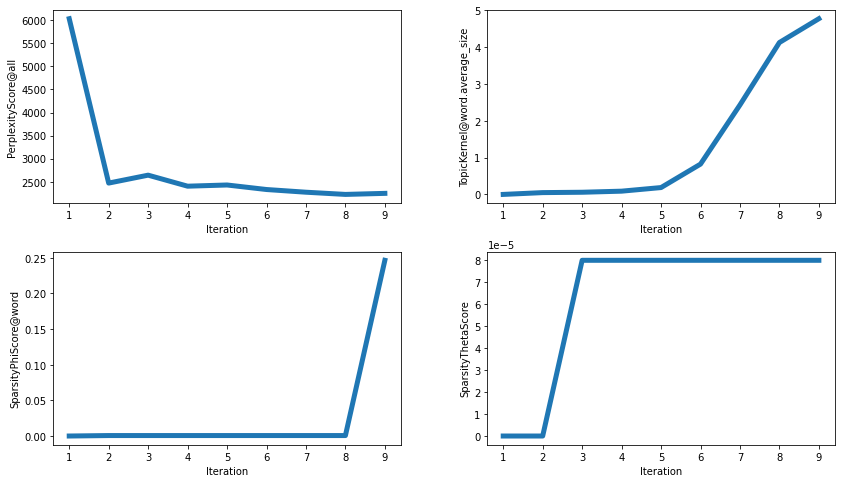

In [264]:
draw_plots(best_model)

In [265]:
model_quality = ESTIMATES._estimate_model_quality(best_model)

In [267]:
ESTIMATES.update({ 'soph_aooa': model_quality })

In [136]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'arora_0', 'arora_1', 'arora_2', 'cdc__250_1_0', 'cdc__250_1_1', 'cdc__250_1_2', 'cdc__250_2_0', 'cdc__250_2_1', 'cdc__250_2_2', 'cdc__250_3_0', 'cdc__250_3_1', 'cdc__250_3_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa'])

In [268]:
del topic_model

del decorrelation_tau_converter
del selection_tau_converter
del sparsing_tau_converter

del cube_parameters
del cube

#### Topic Selection & Decorrelation. Changing Parameters<a id="estimation-selection-plus-decorrelation2"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [269]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return cur_iter / NUM_CUBE_ITERATIONS * DECORRELATION_TAU
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return 0.0
    elif cur_iter <= 2 * NUM_CUBE_ITERATIONS:
        return (cur_iter - NUM_CUBE_ITERATIONS) / NUM_CUBE_ITERATIONS * SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter > 2 * NUM_CUBE_ITERATIONS: 
        return (cur_iter - 2 * NUM_CUBE_ITERATIONS) / NUM_CUBE_ITERATIONS * SPARSING_TAU
    else:
        return 0.0

In [270]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]

cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False,
)

In [271]:
topic_model = initialize_topic_model()

In [272]:
%%time

models = cube(topic_model, DATASET)

CPU times: user 15min 40s, sys: 4.12 s, total: 15min 44s
Wall time: 14min 25s


In [273]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

../../topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-10__14-50-08)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
../../topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [274]:
best_model

Model(id=--14h50m10s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__14-50-08)

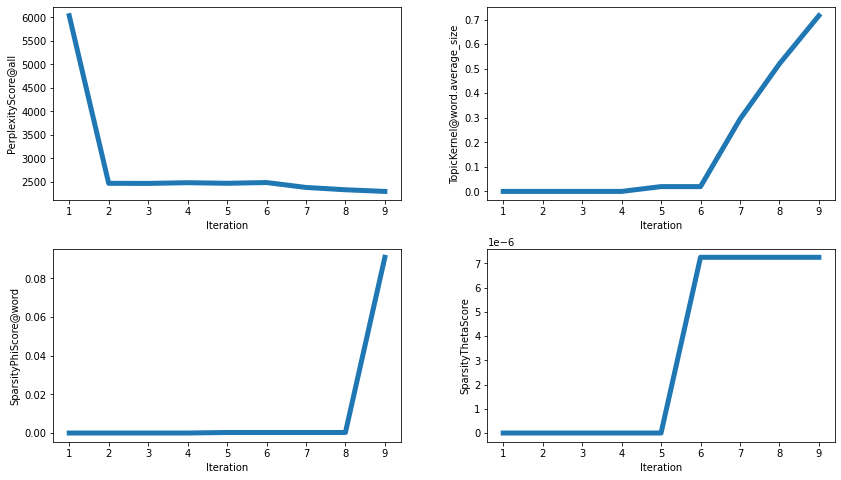

In [276]:
draw_plots(best_model)

In [277]:
model_quality = ESTIMATES._estimate_model_quality(best_model)

In [278]:
ESTIMATES.update({'soph_cp': model_quality})

In [279]:
del topic_model

del decorrelation_tau_converter
del selection_tau_converter
del sparsing_tau_converter

del cube_parameters
del cube

#### Topic Selection & Decorrelation. Alternating Order<a id="estimation-selection-plus-decorrelation3"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [280]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        if cur_iter % 2 == 1:
            return DECORRELATION_TAU
        else:
            return 0.0
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter <= NUM_CUBE_ITERATIONS:
        return 0.0
    elif cur_iter <= 2 * NUM_CUBE_ITERATIONS:
        if cur_iter % 2 == 1:
            return 0.0
        else:
            return SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    if cur_iter > 2 * NUM_CUBE_ITERATIONS: 
        return SPARSING_TAU
    else:
        return 0.0

In [281]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]

cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False,
)

In [282]:
topic_model = initialize_topic_model()

In [283]:
%%time

models = cube(topic_model, DATASET)

CPU times: user 16min 9s, sys: 4.96 s, total: 16min 14s
Wall time: 14min 39s


In [284]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

../../topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-10__15-04-41)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
../../topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [285]:
best_model

Model(id=--15h04m43s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__15-04-41)

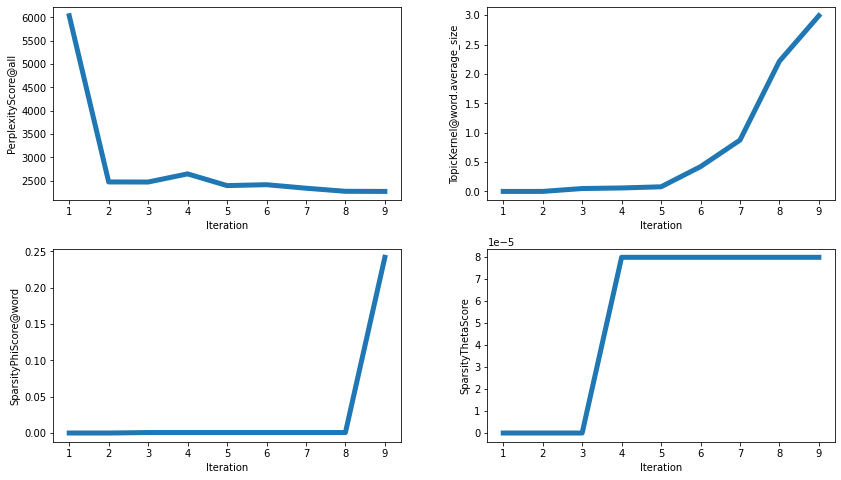

In [287]:
draw_plots(best_model)

In [288]:
model_quality = ESTIMATES._estimate_model_quality(best_model)

In [289]:
ESTIMATES.update({'soph_ao': model_quality})

In [198]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'arora_0', 'arora_1', 'arora_2', 'cdc_0', 'cdc_1', 'cdc_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao'])

In [290]:
del topic_model

del decorrelation_tau_converter
del selection_tau_converter
del sparsing_tau_converter

del cube_parameters
del cube

#### Topic Selection & Decorrelation. Alternating Order & Changing Parameters<a id="estimation-selection-plus-decorrelation4"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [291]:
def decorrelation_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    end_iteration = 2 * NUM_CUBE_ITERATIONS

    if cur_iter <= end_iteration:
        if cur_iter % 2 == 1:
            return max(1, cur_iter / NUM_CUBE_ITERATIONS) * DECORRELATION_TAU
        else:
            return 0.0
    else:
        return 0.0

def selection_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    start_iteration = NUM_CUBE_ITERATIONS // 4  # after some time since decorrelation started
    end_iteration = 2 * NUM_CUBE_ITERATIONS + 3 * NUM_CUBE_ITERATIONS // 4

    if cur_iter <= start_iteration:
        return 0.0
    elif cur_iter <= end_iteration:
        if cur_iter % 2 == 1:
            return 0.0
        else:
            return max(1, (cur_iter - start_iteration) / NUM_CUBE_ITERATIONS) * SELECTION_TAU
    else:
        return 0.0

def sparsing_tau_converter(initial_tau, prev_tau, cur_iter, user_value):
    start_iteration = 2 * NUM_CUBE_ITERATIONS

    if cur_iter > start_iteration: 
        return max(1, (cur_iter - start_iteration) / NUM_CUBE_ITERATIONS) * SPARSING_TAU
    else:
        return 0.0

In [292]:
cube_parameters = [
    {
        'reg_name': DECORRELATE_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': decorrelation_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SELECT_TOPICS,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': selection_tau_converter,
        'user_value_grid': [0]
    },
    {
        'reg_name': SPARSE_PHI_SPECIFIC,
        'score_to_track': PERPLEXITY_SCORE + MAIN_MODALITY,
        'tau_converter': sparsing_tau_converter,
        'user_value_grid': [0]
    }
]

cube = RegularizationControllerCube(
    num_iter=3 * NUM_CUBE_ITERATIONS,
    parameters=cube_parameters,
    reg_search='grid',
    use_relative_coefficients=False,
    separate_thread=False,
)

In [293]:
topic_model = initialize_topic_model()

In [294]:
%%time

models = cube(topic_model, DATASET)

../../topicnet/cooking_machine/cubes/controller_cube.py:162: UserWarning: Score PerplexityScore@word is too high: during training the value 8914.4189453125 passed a treshold of 2461.2415283203127 (estimate is based on 6 iteration)
  warnings.warn(msg)
../../topicnet/cooking_machine/cubes/controller_cube.py:264: UserWarning: Process of dynamically changing tau was stopped at 8 iteration
  warnings.warn(W_HALT_CONTROL.format(len(self.tau_history)))


CPU times: user 16min 23s, sys: 5.22 s, total: 16min 29s
Wall time: 14min 39s


In [295]:
best_model = select_best_model_of_all(
    experiment=topic_model.experiment,
)

../../topicnet/cooking_machine/routine.py:455: UserWarning: Model "Model(id=-----------root-----------, parent_id=None, experiment_id=2020-05-10__15-19-29)" has empty value list for score "PerplexityScore@word"
  f'Model \"{acceptable_model}\" has empty value list for score \"{metric}\"')
../../topicnet/cooking_machine/routine.py:484: UserWarning: Can't return the requested number of models:
  warnings.warn(W_RETURN_FEWER_MODELS.format(models_num, len(result_models)))


In [296]:
best_model

Model(id=--15h19m30s_10d05m2020y---, parent_id=-----------root-----------, experiment_id=2020-05-10__15-19-29)

In [ ]:
draw_plots(best_model)

In [302]:
model_quality = ESTIMATES._estimate_model_quality(
    best_model,
)

In [303]:
ESTIMATES.update({'soph_aocp': model_quality})

In [305]:
ESTIMATES._model2estimates.keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'arora__100_1_0', 'arora__100_1_1', 'arora__100_1_2', 'cdc__100_1_0', 'cdc__100_1_1', 'cdc__100_1_2', 'arora__100_2_0', 'arora__100_2_1', 'arora__100_2_2', 'cdc__100_2_0', 'cdc__100_2_1', 'cdc__100_2_2', 'arora__100_3_0', 'arora__100_3_1', 'arora__100_3_2', 'cdc__100_3_0', 'cdc__100_3_1', 'cdc__100_3_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp'])

## Results<a id="results"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [80]:
ESTIMATES = dict()

for dataset_folder_name in DatasetName:
    estimates_file_path = os.path.join(
        get_dataset_internals_folder_path(dataset_folder_name),
        'quality_estimates.json',
    )

    ESTIMATES[dataset_folder_name] = json.loads(
        open(estimates_file_path, 'r').read()
    )

In [83]:
SAMPLE_DATASET_NAME = DatasetName.POSTNAUKA

In [84]:
ESTIMATES[SAMPLE_DATASET_NAME].keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp', 'arora__20_0_0', 'arora__20_0_1', 'arora__20_0_2', 'cdc__20_0_0', 'cdc__20_0_1', 'cdc__20_0_2', 'arora__15_1_0', 'arora__15_1_1', 'arora__15_1_2', 'cdc__15_1_0', 'cdc__15_1_1', 'cdc__15_1_2', 'arora__15_2_0', 'arora__15_2_1', 'arora__15_2_2', 'cdc__15_2_0', 'cdc__15_2_1', 'cdc__15_2_2'])

### Step 0. Fixing Keys<a id="step0"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [85]:
ESTIMATES[SAMPLE_DATASET_NAME]['plsa_0'].keys()

dict_keys(['0.1', '0.15000000000000002', '0.20000000000000004', '0.25000000000000006', '0.30000000000000004', '0.3500000000000001', '0.40000000000000013', '0.45000000000000007', '0.5000000000000001', '0.5500000000000002', '0.6000000000000002', '0.6500000000000001', '0.7000000000000002', '0.7500000000000002', '0.8000000000000002', '0.8500000000000002', '0.9000000000000002'])

In [86]:
ESTIMATES[SAMPLE_DATASET_NAME]['plsa_0']['0.1'].keys()

dict_keys(['num_good_topics', 'num_found_topics', 'found_topics', 'coherence@bank', 'precision@bank', 'recall@bank', 'cost', '_num_model_topics', '_num_bank_topics'])

In [87]:
def fix_key(key: str) -> float:
    return int(float(key) * 100) / 100

In [88]:
fix_key('0.1')

0.1

In [90]:
new_estimates = dict()

for dataset_folder_name in DatasetName:
    new_dataset_estimates = dict()
    dataset_estimates = ESTIMATES[dataset_folder_name]

    for model, threshold_metrics in dataset_estimates.items():
        new_threshold_metrics = dict()

        for threshold, metrics in threshold_metrics.items():
            new_threshold_metrics[fix_key(threshold)] = copy.deepcopy(metrics)

        new_dataset_estimates[model] = new_threshold_metrics
    
    new_estimates[dataset_folder_name] = new_dataset_estimates

In [91]:
new_estimates[SAMPLE_DATASET_NAME].keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp', 'arora__20_0_0', 'arora__20_0_1', 'arora__20_0_2', 'cdc__20_0_0', 'cdc__20_0_1', 'cdc__20_0_2', 'arora__15_1_0', 'arora__15_1_1', 'arora__15_1_2', 'cdc__15_1_0', 'cdc__15_1_1', 'cdc__15_1_2', 'arora__15_2_0', 'arora__15_2_1', 'arora__15_2_2', 'cdc__15_2_0', 'cdc__15_2_1', 'cdc__15_2_2'])

In [92]:
new_estimates[SAMPLE_DATASET_NAME]['plsa_0'].keys()

dict_keys([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])

In [93]:
ESTIMATES = new_estimates

In [94]:
ESTIMATES.keys()

dict_keys([<DatasetName.POSTNAUKA: 'Post_Science'>, <DatasetName.REUTERS: 'Reuters'>, <DatasetName.BROWN: 'Brown'>, <DatasetName.TWENTY_NEWSGROUPS: '20NG_natural_order'>, <DatasetName.AG_NEWS: 'AG_News'>, <DatasetName.WATAN: 'Watan2004'>, <DatasetName.HABRAHABR: 'Habrahabr'>])

### Step 1. Averaging<a id="step1"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [95]:
ESTIMATES[SAMPLE_DATASET_NAME]['plsa_0'].keys()

dict_keys([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])

In [96]:
ESTIMATES[SAMPLE_DATASET_NAME]['plsa_0'][0.45]

{'num_good_topics': 6,
 'num_found_topics': 6,
 'found_topics': ['topic_15',
  'topic_9',
  'topic_3',
  'topic_5',
  'topic_14',
  'topic_8'],
 'coherence@bank': 0.06,
 'precision@bank': 0.06,
 'recall@bank': 0.25,
 'cost': 15.407293319702148,
 '_num_model_topics': 100,
 '_num_bank_topics': 24}

In [97]:
def compute_coherence_at_bank(num_good_topics: int, num_model_topics: int) -> float:
    return num_good_topics / max(1, num_model_topics)

def compute_precision_at_bank(num_found_topics: int, num_model_topics: int) -> float:
    return num_found_topics / max(1, num_model_topics)

def compute_recall_at_bank(num_found_topics: int, num_bank_topics: int) -> float:
    return num_found_topics / max(1, num_bank_topics)

In [98]:
sample_data = copy.deepcopy(ESTIMATES[SAMPLE_DATASET_NAME]['plsa_0'][0.45])

In [99]:
sample_data

{'num_good_topics': 6,
 'num_found_topics': 6,
 'found_topics': ['topic_15',
  'topic_9',
  'topic_3',
  'topic_5',
  'topic_14',
  'topic_8'],
 'coherence@bank': 0.06,
 'precision@bank': 0.06,
 'recall@bank': 0.25,
 'cost': 15.407293319702148,
 '_num_model_topics': 100,
 '_num_bank_topics': 24}

In [100]:
compute_coherence_at_bank(
    num_good_topics=sample_data['num_good_topics'],
    num_model_topics=sample_data['_num_model_topics']
) == sample_data['coherence@bank']

True

In [101]:
compute_precision_at_bank(
    num_found_topics=sample_data['num_found_topics'],
    num_model_topics=sample_data['_num_model_topics']
) == sample_data['precision@bank']

True

In [102]:
compute_recall_at_bank(
    num_found_topics=sample_data['num_found_topics'],
    num_bank_topics=sample_data['_num_bank_topics']
) == sample_data['recall@bank']

True

In [103]:
ESTIMATES[SAMPLE_DATASET_NAME].keys()

dict_keys(['plsa_0', 'plsa_1', 'plsa_2', 'regularized_0', 'regularized_1', 'regularized_2', 'background_topics_0', 'background_topics_1', 'background_topics_2', 'lda_0', 'lda_1', 'lda_2', 'sparse_0', 'sparse_1', 'sparse_2', 'decorrelation_0', 'decorrelation_1', 'decorrelation_2', 'artm_0', 'artm_1', 'artm_2', 'soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp', 'arora__20_0_0', 'arora__20_0_1', 'arora__20_0_2', 'cdc__20_0_0', 'cdc__20_0_1', 'cdc__20_0_2', 'arora__15_1_0', 'arora__15_1_1', 'arora__15_1_2', 'cdc__15_1_0', 'cdc__15_1_1', 'cdc__15_1_2', 'arora__15_2_0', 'arora__15_2_1', 'arora__15_2_2', 'cdc__15_2_0', 'cdc__15_2_1', 'cdc__15_2_2'])

In [104]:
def average_for_model(dataset_estimates, source_names: List[str]) -> dict:
    if len(source_names) == 0:
        raise ValueError()

    result_metrics = dict()

    for threshold in dataset_estimates[source_names[0]]:
        metrics_for_threshold = dict()

        
        for k in ['num_good_topics', 'cost', 'num_found_topics']:
            metrics_for_threshold[k] = 0

            for n in source_names:
                metrics_for_threshold[k] += dataset_estimates[n][threshold][k]

            metrics_for_threshold[k] /= 3.0
        
        
#         metrics_for_threshold['found_topics'] = list()
        
#         for n in source_names:
#             metrics_for_threshold['found_topics'] += DATA[n][threshold]['found_topics']
        
#         metrics_for_threshold['found_topics'] = list(
#             set(metrics_for_threshold['found_topics'])
#         )
#         metrics_for_threshold['num_found_topics'] = len(metrics_for_threshold['found_topics'])
        
        
        assert all(
            dataset_estimates[n][threshold]['_num_model_topics'] == dataset_estimates[source_names[0]][threshold]['_num_model_topics']
            for n in source_names[1:]
        )
        assert all(
            dataset_estimates[n][threshold]['_num_bank_topics'] == dataset_estimates[source_names[0]][threshold]['_num_bank_topics']
            for n in source_names[1:]
        )
        
        metrics_for_threshold['_num_model_topics'] = dataset_estimates[source_names[0]][threshold]['_num_model_topics']
        metrics_for_threshold['_num_bank_topics'] = dataset_estimates[source_names[0]][threshold]['_num_bank_topics']
        
        
        metrics_for_threshold['coherence@bank'] = compute_coherence_at_bank(
            num_good_topics=metrics_for_threshold['num_good_topics'],
            num_model_topics=metrics_for_threshold['_num_model_topics']
        )
        metrics_for_threshold['precision@bank'] = compute_precision_at_bank(
            num_found_topics=metrics_for_threshold['num_found_topics'],
            num_model_topics=metrics_for_threshold['_num_model_topics']
        )
        metrics_for_threshold['recall@bank'] = compute_recall_at_bank(
            num_found_topics=metrics_for_threshold['num_found_topics'],
            num_bank_topics=metrics_for_threshold['_num_bank_topics']
        )
        
        
        result_metrics[threshold] = metrics_for_threshold
    
    return result_metrics

In [105]:
averaged = average_for_model(
    ESTIMATES[SAMPLE_DATASET_NAME],
    [f'plsa_{i}' for i in [0, 1, 2]]
)

In [106]:
averaged[0.1]

{'num_good_topics': 0.0,
 'cost': 15.647758483886719,
 'num_found_topics': 0.0,
 '_num_model_topics': 100,
 '_num_bank_topics': 24,
 'coherence@bank': 0.0,
 'precision@bank': 0.0,
 'recall@bank': 0.0}

In [107]:
for dataset_folder_name in DatasetName:
    dataset_estimates = ESTIMATES[dataset_folder_name]
    dataset_model_names = list(dataset_estimates.keys())

    for model_name in [
            'plsa', 'regularized', 'background_topics',
            'arora', 'cdc', 'lda',  'sparse', 'decorrelation', 'artm']:

        source_names = [n for n in dataset_model_names if n.startswith(model_name)]

        dataset_estimates[model_name] = average_for_model(dataset_estimates, source_names)

        for n in source_names:
            del dataset_estimates[n]

In [108]:
ESTIMATES[SAMPLE_DATASET_NAME].keys()

dict_keys(['soph_aooa', 'soph_cp', 'soph_ao', 'soph_aocp', 'plsa', 'regularized', 'background_topics', 'arora', 'cdc', 'lda', 'sparse', 'decorrelation', 'artm'])

In [130]:
MODEL_ID_TO_LABEL = {
    'arora': 'arora',
    'artm': 'reg2',
    'background_topics': 'bcg_topics',
    'cdc': 'cdc',
    'decorrelation': 'decorr',
    'lda': 'lda',
    'plsa': 'plsa',
    'regularized': 'reg1',
    'sparse': 'sparse',
    'soph_aooa': 'sel_aooa',
    'soph_cp': 'sel_cp',
    'soph_ao': 'sel_ao',
    'soph_aocp': 'sel_aocp',
}

In [131]:
assert all(m in MODEL_ID_TO_LABEL for m in ESTIMATES[SAMPLE_DATASET_NAME].keys())

In [109]:
THRESHOLDS = sorted(list(ESTIMATES[SAMPLE_DATASET_NAME]['plsa'].keys()))

In [110]:
THRESHOLDS

[0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9]

In [115]:
THRESHOLD_TO_WEIGHT = {
    t: 1.0 / (t ** 2) if t <= 0.8 else 0 for t in THRESHOLDS
}

In [116]:
THRESHOLD_TO_WEIGHT

{0.1: 99.99999999999999,
 0.15: 44.44444444444444,
 0.2: 24.999999999999996,
 0.25: 16.0,
 0.3: 11.11111111111111,
 0.35: 8.163265306122451,
 0.4: 6.249999999999999,
 0.45: 4.938271604938271,
 0.5: 4.0,
 0.55: 3.305785123966942,
 0.6: 2.7777777777777777,
 0.65: 2.3668639053254434,
 0.7: 2.0408163265306127,
 0.75: 1.7777777777777777,
 0.8: 1.5624999999999998,
 0.85: 0,
 0.9: 0}

In [117]:
ESTIMATES[SAMPLE_DATASET_NAME]['arora'][0.1].keys()

dict_keys(['num_good_topics', 'cost', 'num_found_topics', '_num_model_topics', '_num_bank_topics', 'coherence@bank', 'precision@bank', 'recall@bank'])

In [118]:
METRICS_TO_AVERAGE = [
    'coherence@bank', 'precision@bank', 'recall@bank',
    'cost'  # actually no, but yes
]

In [119]:
AVERAGED_ESTIMATES = dict()

for dataset_folder_name in DatasetName:
    dataset_estimates = ESTIMATES[dataset_folder_name]
    averaged_dataset_estimates = dict()

    for m in dataset_estimates:
        averaged_dataset_estimates[m] = dict()

        for metric in METRICS_TO_AVERAGE:
            averaged_dataset_estimates[m][metric] = 0.0

            for t, w in THRESHOLD_TO_WEIGHT.items():
                if metric != 'cost':
                    normalization_coefficient = 1.0
                else:
                    normalization_coefficient = 1.0 / min(
                        dataset_estimates[m][t]['_num_model_topics'],
                        dataset_estimates[m][t]['_num_bank_topics'],
                    )

                averaged_dataset_estimates[m][metric] += (
                    dataset_estimates[m][t][metric] * normalization_coefficient * w
                )

            averaged_dataset_estimates[m][metric] = 1.0 * averaged_dataset_estimates[m][metric] / sum(
                list(THRESHOLD_TO_WEIGHT.values())
            )
            
            if metric == 'cost':
                averaged_dataset_estimates[m]['reversed_cost'] = (
                    1.0 / averaged_dataset_estimates[m][metric]
                )
    
    AVERAGED_ESTIMATES[dataset_folder_name] = averaged_dataset_estimates

In [120]:
AVERAGED_ESTIMATES[SAMPLE_DATASET_NAME]['plsa']

{'coherence@bank': 0.011363751691628583,
 'precision@bank': 0.012363251406680048,
 'recall@bank': 0.05151354752783354,
 'cost': 0.6519899368286134,
 'reversed_cost': 1.533766003911295}

### Step 2. Aggregating<a id="step2"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [121]:
def aggregate_metrics(metric, data_for_datasets: List):
    model2value = dict()
    
    data_for_datasets = copy.deepcopy(data_for_datasets)
    
    for data in data_for_datasets:
        total_value = sum(model_metrics[metric] for model_metrics in data.values())
        
        for model, model_metrics in data.items():
            # TODO
            model_metrics[metric] = 1.0 * model_metrics[metric] / total_value
    
    models = list(data_for_datasets[0].keys())
    
    for m in models:
        model2value[m] = 0
        
        for data in data_for_datasets:
            assert sorted(list(data.keys())) == sorted(models)
            
            model2value[m] += data[m][metric]
        
        model2value[m] = 1.0 * model2value[m] / len(data_for_datasets)
    
    return model2value

In [122]:
aggregated = aggregate_metrics(
    'coherence@bank',
    [AVERAGED_ESTIMATES[SAMPLE_DATASET_NAME]]
)

In [123]:
aggregated

{'soph_aooa': 0.004583857335587732,
 'soph_cp': 0.007958521315075193,
 'soph_ao': 0.007581866727137529,
 'soph_aocp': 0.0018970900209039814,
 'plsa': 0.10483302098992209,
 'regularized': 0.029136474623440326,
 'background_topics': 0.10628634598598231,
 'arora': 0.18172494363191416,
 'cdc': 0.16469168689427127,
 'lda': 0.11932552590763092,
 'sparse': 0.0757716864610296,
 'decorrelation': 0.13439841424714485,
 'artm': 0.06181056585996005}

In [125]:
sum(aggregated.values())

0.9999999999999999

### Step 3. Plots<a id="step3"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

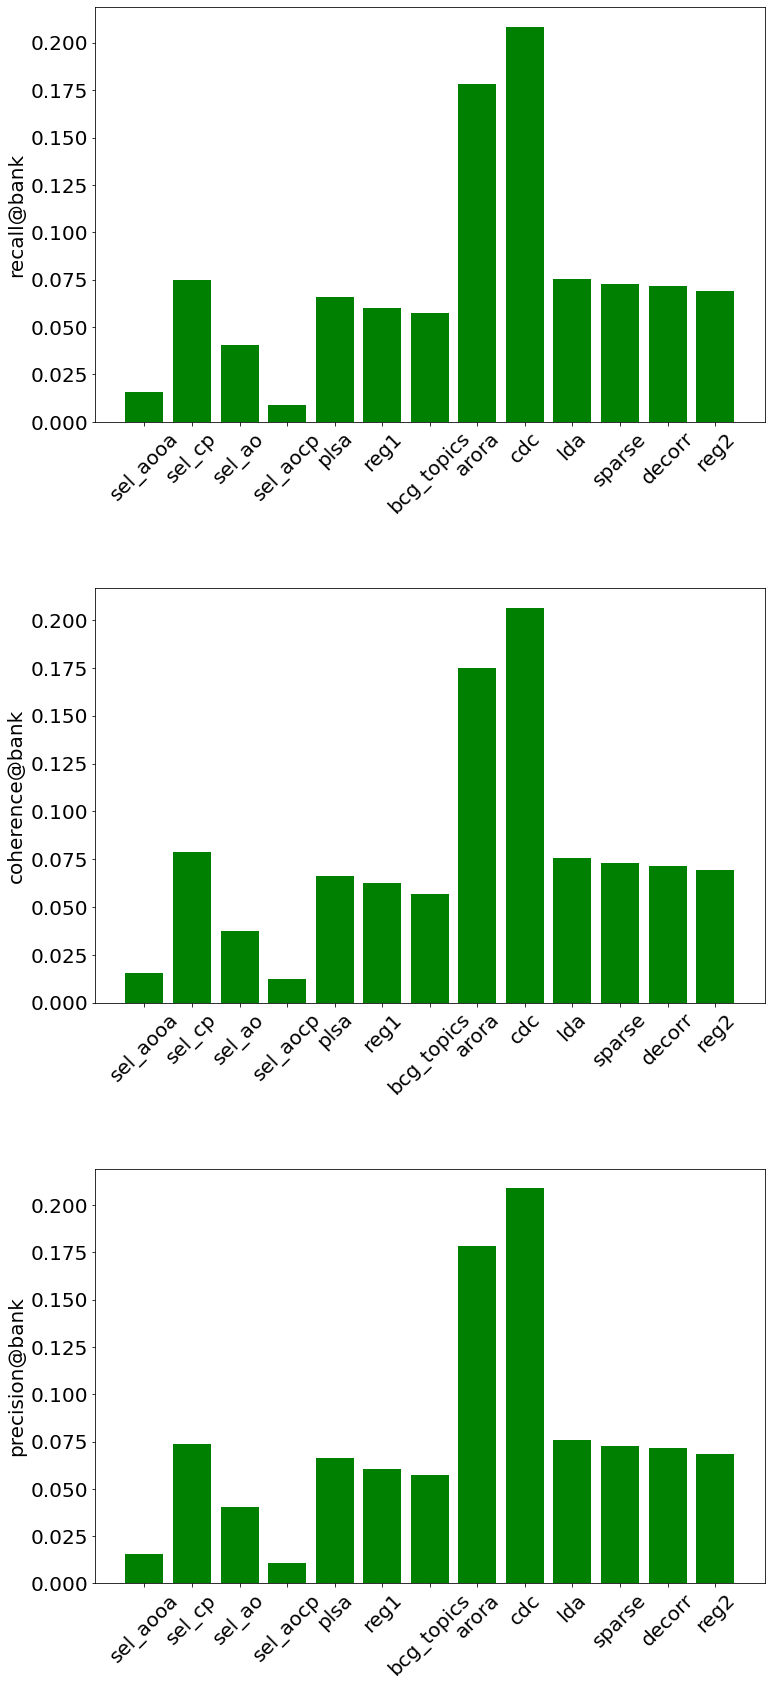

In [140]:
metrics = [
    'recall@bank',
    'coherence@bank',
    'precision@bank',
]
data_for_datasets = list(AVERAGED_ESTIMATES.values())

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 8 * len(metrics) + 5))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4
)

for ax, metric in zip(axes, metrics):
    aggregated = aggregate_metrics(
        metric,
        data_for_datasets,
    )

    labels = [MODEL_ID_TO_LABEL[m] for m in aggregated.keys()]
    ticks = list(range(len(labels)))

    ax.bar(ticks, aggregated.values(), color='g')

    ax.set_ylabel(metric)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)

plt.show()

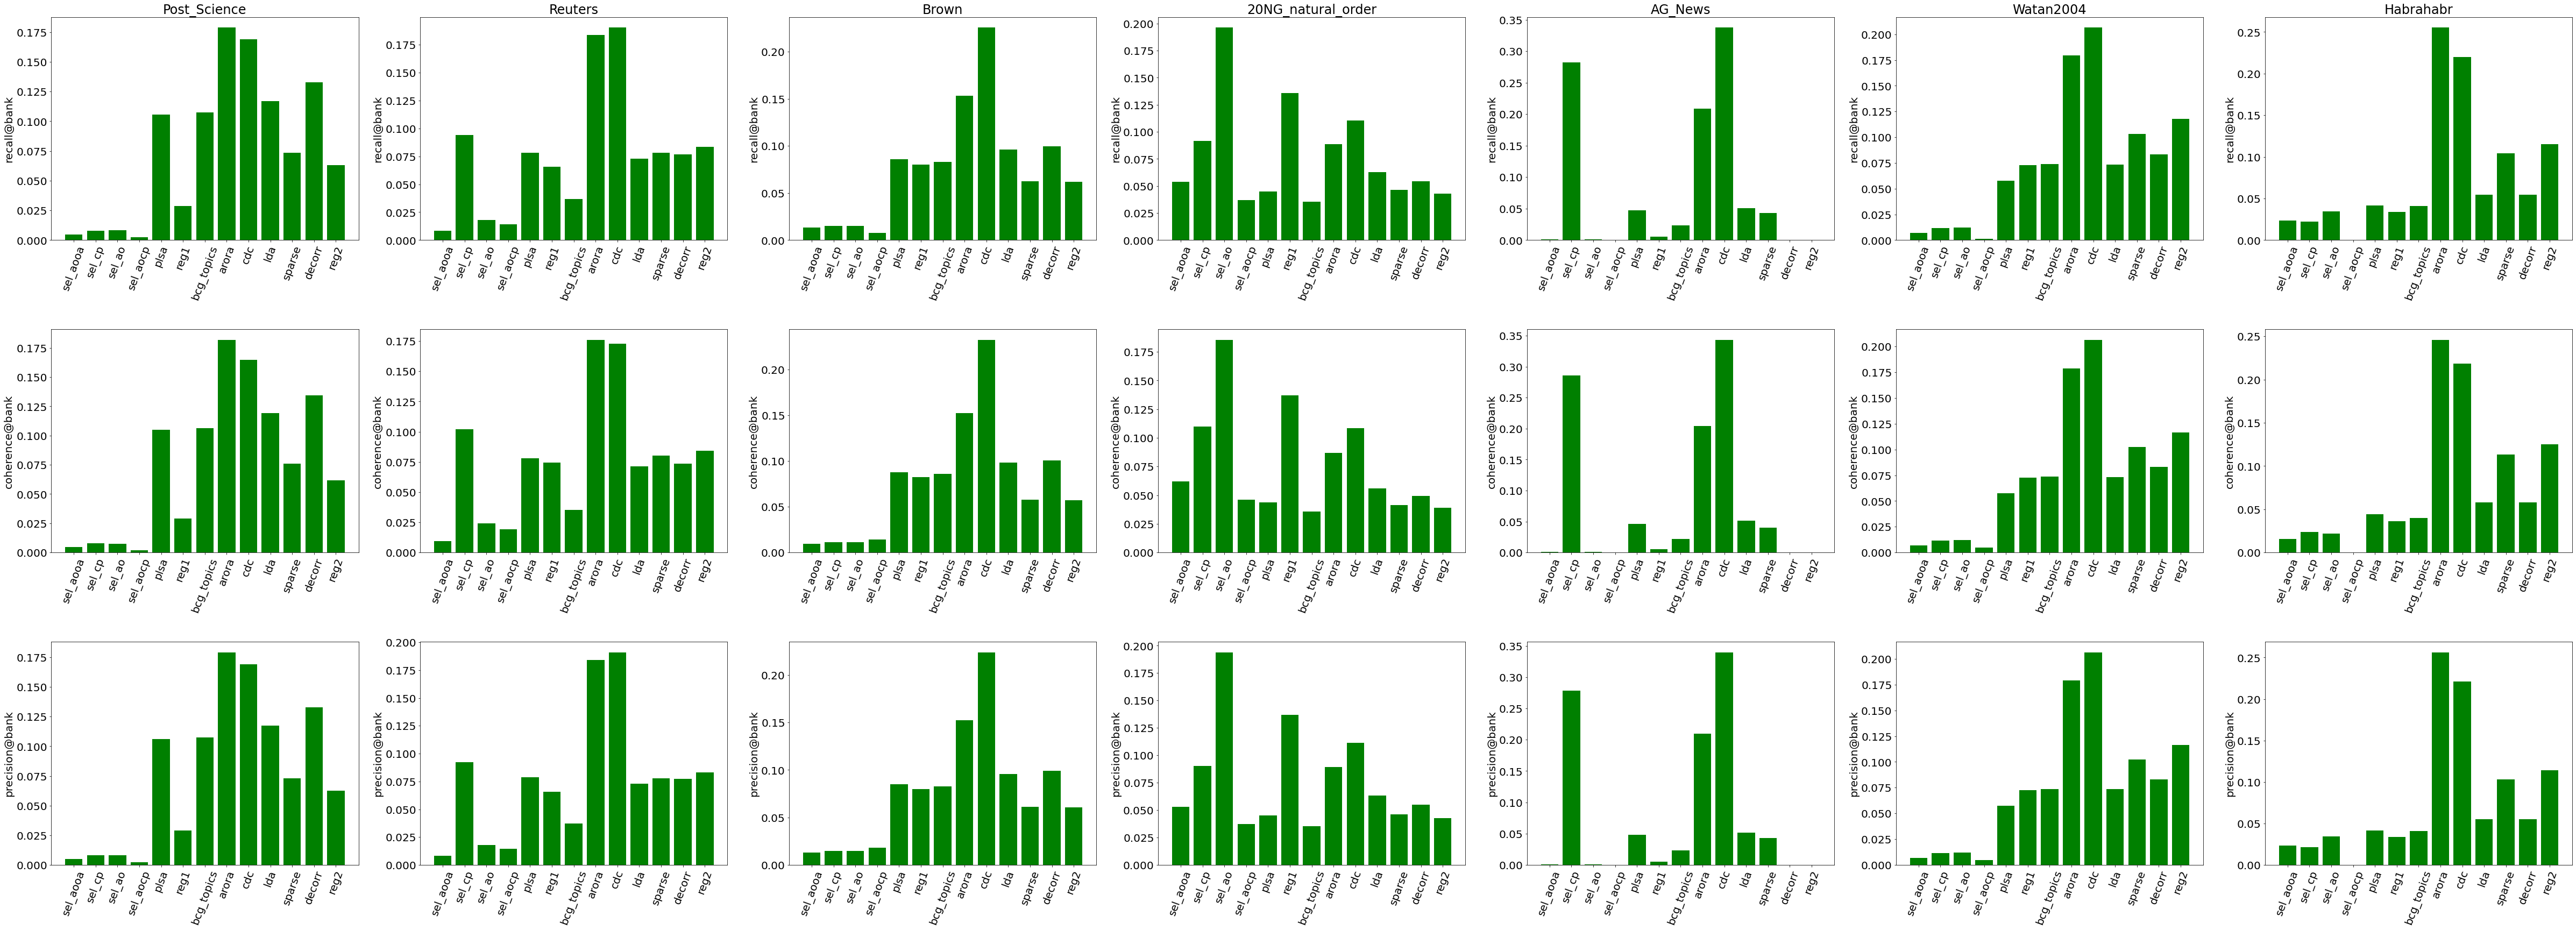

In [139]:
metrics = [
    'recall@bank',
    'coherence@bank',
    'precision@bank',
]

fig, axes = plt.subplots(
    len(metrics), len(DatasetFolderName),
    figsize=(12 * len(DatasetFolderName), 8 * len(metrics) + 5)
)

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4
)

for j, dataset_folder_name in enumerate(DatasetName):
    data_for_datasets = [AVERAGED_ESTIMATES[dataset_folder_name]]
    
    for i, metric in enumerate(metrics):
        ax = axes[i, j]

        aggregated = aggregate_metrics(
            metric,
            data_for_datasets,
        )

        labels = [MODEL_ID_TO_LABEL[m] for m in aggregated.keys()]
        ticks = list(range(len(labels)))

        ax.bar(ticks, aggregated.values(), color='g')

        ax.set_ylabel(metric)
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels, rotation=70)
        
        if i == 0:
            ax.set_title(dataset_folder_name.value)

plt.show()